# Biblioteca

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime, timedelta, date

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## tirar os warnings nao eh uma boa pratica, mas como os avisos ja foram mapeados
## optou-se por retira-los pra manter o codigo mais limpo e coeso
import warnings 
warnings.filterwarnings("ignore")

# Funcoes

In [3]:
def moving_average_test2(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0]):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


# Acessando arquivos


In [4]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [5]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/viagens_mapeadas.xlsx', index_col='Unnamed: 0')

#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

In [6]:
# viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 8,'distance(m)' ]


# fig, ax = plt.subplots(nrows = 1, ncols= 3,sharex=True, sharey=True, figsize=(16,6))

# ax[0].hist(viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 6,'distance(m)' ])
# ax[1].hist(viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 7,'distance(m)' ])
# ax[2].hist(viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 8,'distance(m)' ])


# ax[0].set_ylabel('Frequência'), ax[1].set_ylabel('Frequência'),ax[2].set_ylabel('Frequência')
# ax[0].set_xlabel('Distância Percorrida (m)'),ax[1].set_xlabel('Distância Percorrida (m)'),ax[2].set_xlabel('Distância Percorrida (m)')

# ax[0].set_title('Junho')
# ax[1].set_title('Julho')
# ax[2].set_title('Agosto')



# plt.show();

In [7]:
# viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 8,'duration(s)' ]


# fig, ax = plt.subplots(nrows = 1, ncols= 3,sharex=True, sharey=True, figsize=(16,6))

# ax[0].hist(viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 6,'duration(s)' ])
# ax[1].hist(viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 7,'duration(s)' ])
# ax[2].hist(viagens_validas.loc[viagens_validas['dataInicio'].dt.month == 8,'duration(s)' ])


# ax[0].set_ylabel('Frequência'), ax[1].set_ylabel('Frequência'),ax[2].set_ylabel('Frequência')
# ax[0].set_xlabel('Duração da Conexão (s)'),ax[1].set_xlabel('Duração da Conexão (s)'),ax[2].set_xlabel('Duração da Conexão (s)')

# ax[0].set_title('Junho')
# ax[1].set_title('Julho')
# ax[2].set_title('Agosto')



# plt.show();

# Volume por dia da semana

## Organizacao dos volumes por dias da semana

0    3030
1    3067
2    3161
3    2740
4    2489
Name: dataInicio, dtype: int64


<AxesSubplot:title={'center':'Soma dos Volumes por dia da Semana'}>

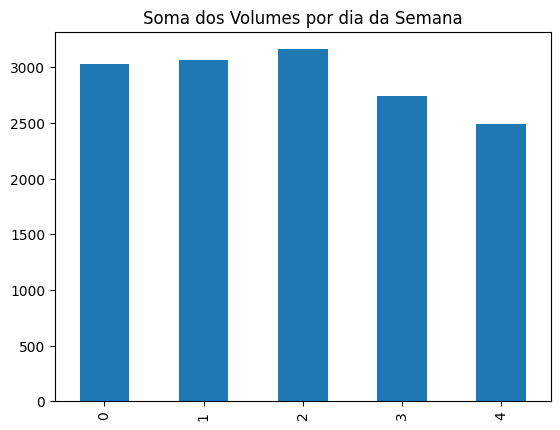

In [8]:
# 0 --> segunda
viagens_validas = viagens_validas.loc[viagens_validas.dataInicio.dt.day_of_week != 5]

print(viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index())
viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index().plot(kind = 'bar', title='Soma dos Volumes por dia da Semana')


In [9]:
vol_semanal = viagens_validas.groupby(['day_of_week', pd.Grouper(freq='1D',key = 'dataInicio')]).agg({'sequence':'count'}).reset_index()
vol_semanal.drop(index = vol_semanal.loc[vol_semanal['day_of_week'] == 5].index,inplace = True, axis = 0)
vol_semanal.columns = ['day_of_week',	'Data',	'Volume']

vol_semanal

day_of_week       Data  Volume
0             0 2021-06-07     241
1             0 2021-06-14     287
2             0 2021-06-21     114
3             0 2021-06-28     128
4             0 2021-07-05     256
..          ...        ...     ...
58            4 2021-07-30     246
59            4 2021-08-06     112
60            4 2021-08-13     153
61            4 2021-08-20     281
62            4 2021-08-27     279

[63 rows x 3 columns]

In [10]:
vol_semanal.day_of_week.value_counts()

1    14
0    13
2    13
3    12
4    11
Name: day_of_week, dtype: int64

In [11]:
segundas =  vol_semanal.loc[vol_semanal['day_of_week'] == 0].reset_index(drop=True)
tercas =    vol_semanal.loc[vol_semanal['day_of_week'] == 1].reset_index(drop=True)
quartas =   vol_semanal.loc[vol_semanal['day_of_week'] == 2].reset_index(drop=True)
quintas =   vol_semanal.loc[vol_semanal['day_of_week'] == 3].reset_index(drop=True)
sextas =    vol_semanal.loc[vol_semanal['day_of_week'] == 4].reset_index(drop=True)

In [12]:
quintas

day_of_week       Data  Volume
0             3 2021-06-10     291
1             3 2021-06-17     259
2             3 2021-06-24     277
3             3 2021-07-01     120
4             3 2021-07-08     143
5             3 2021-07-15     301
6             3 2021-07-22     285
7             3 2021-07-29     163
8             3 2021-08-05      81
9             3 2021-08-12     268
10            3 2021-08-19     262
11            3 2021-08-26     290

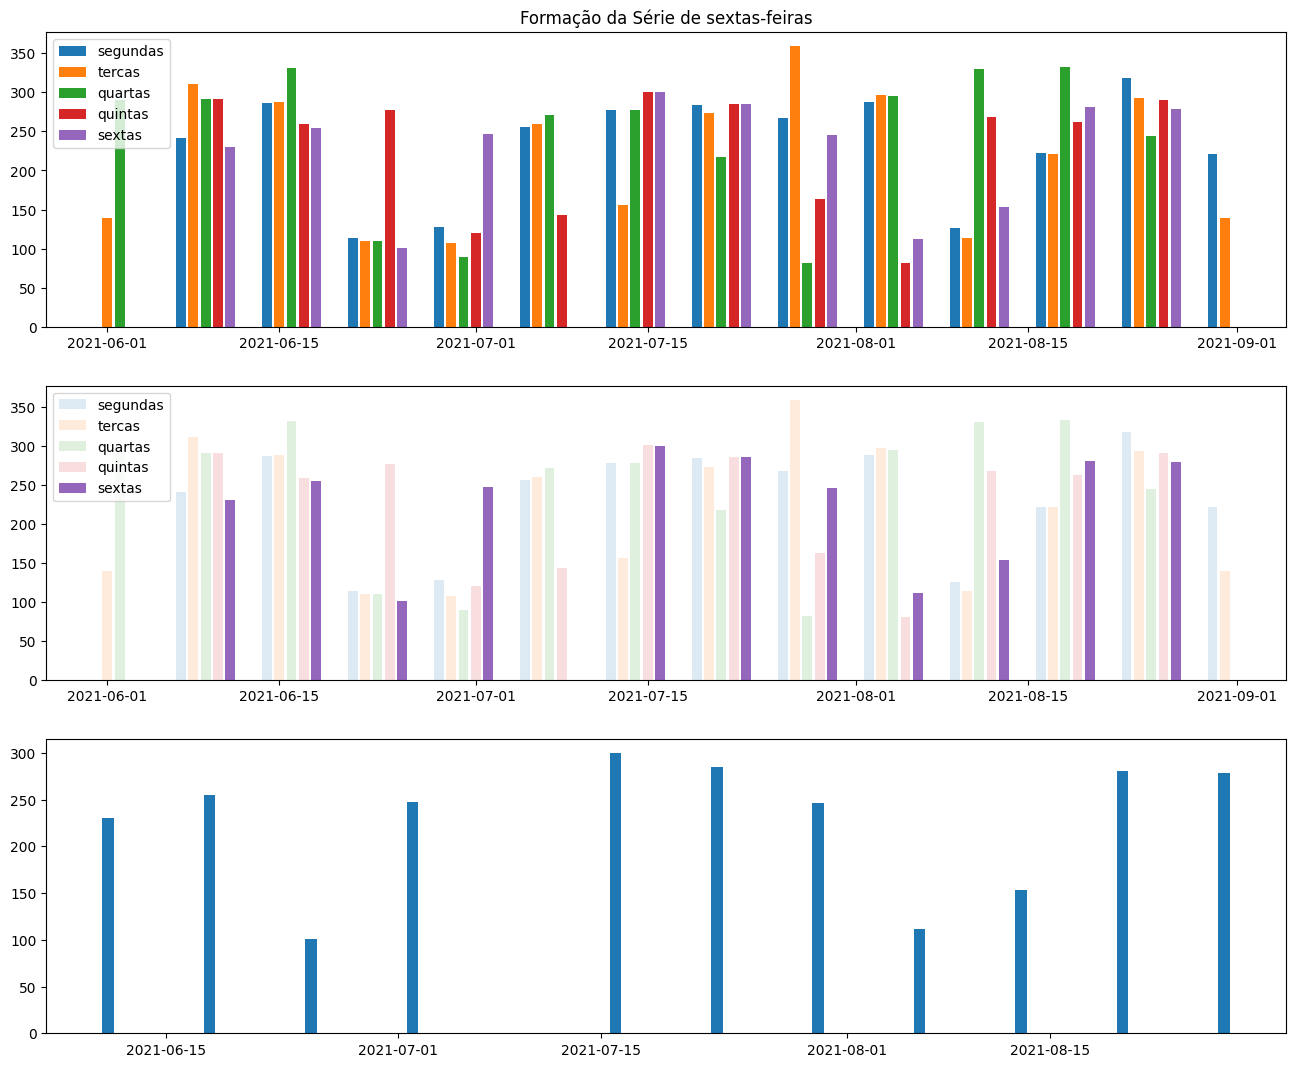

In [43]:
fig, ax = plt.subplots(nrows = 3,figsize=(16,13))
ax[0].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 0, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 0, 'Volume'])
ax[0].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 1, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 1, 'Volume'])
ax[0].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 2, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 2, 'Volume'])
ax[0].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 3, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 3, 'Volume'])
ax[0].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 4, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 4, 'Volume'])


ax[1].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 0, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 0, 'Volume'], alpha=0.15)
ax[1].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 1, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 1, 'Volume'], alpha=0.15)
ax[1].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 2, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 2, 'Volume'], alpha=0.15)
ax[1].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 3, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 3, 'Volume'], alpha=0.15)
ax[1].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 4, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 4, 'Volume'])

ax[0].legend(labels=['segundas', 'tercas','quartas','quintas','sextas']),ax[1].legend(labels=['segundas', 'tercas','quartas','quintas','sextas'])

ax[2].bar(vol_semanal.loc[vol_semanal['day_of_week'] == 4, 'Data'], vol_semanal.loc[vol_semanal['day_of_week'] == 4, 'Volume'])
ax[0].set_title("Formação da Série de sextas-feiras")

plt.show();


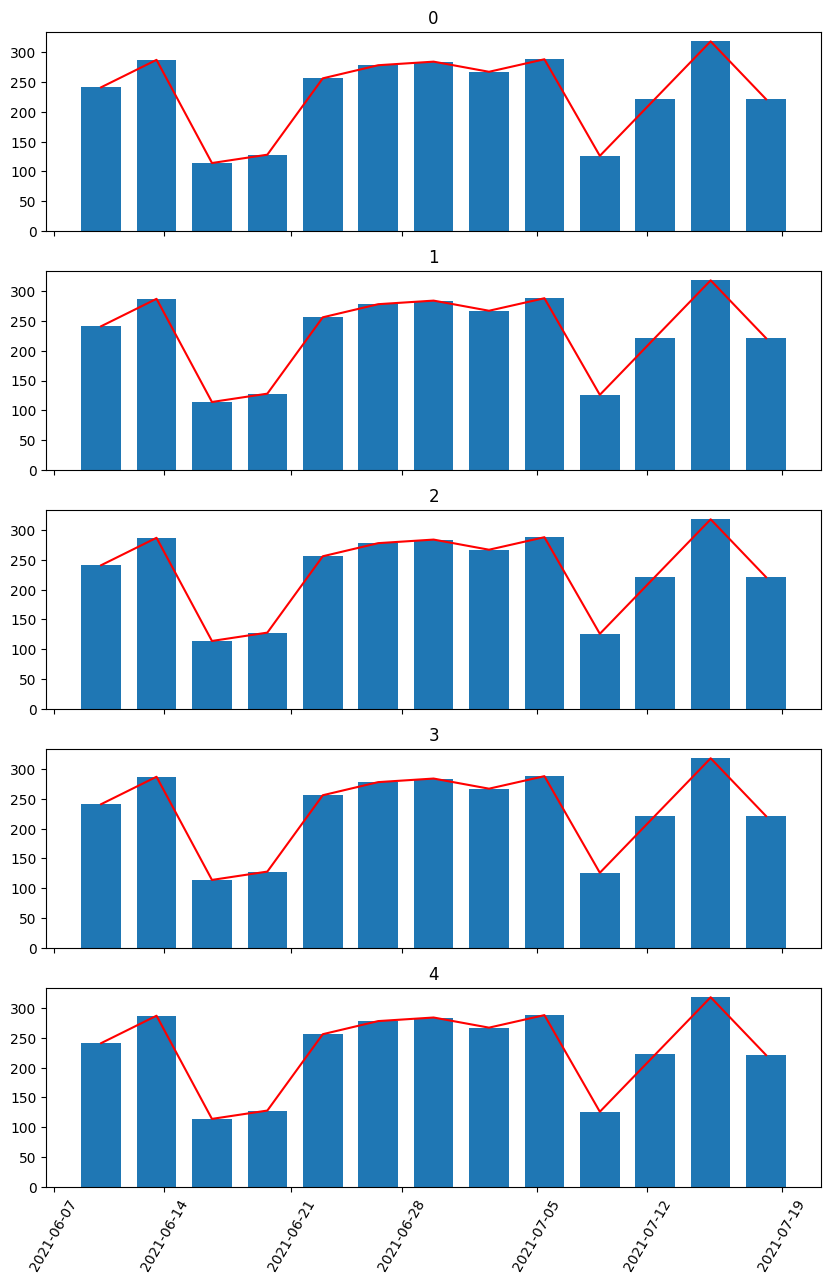

In [14]:
fig, ax = plt.subplots(5,figsize=(10,15), sharex= True, sharey = True)

for ind, weekday in enumerate([segundas, tercas, quartas, quintas, sextas]):
    ax[ind].bar(    segundas   .Data.dt.date, segundas   .Volume, width = 5)
    ax[ind].plot(   segundas   .Data.dt.date, segundas   .Volume, color = 'red')
    ax[ind].set_xticklabels(labels = segundas   .Data.dt.date , rotation = 60)    
    ax[ind].set_title(ind)



In [15]:
X_train_Seg,X_test_Seg  = segundas  [['Data', 'Volume']][:8].reset_index(drop=True), segundas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Ter,X_test_Ter  = tercas    [['Data', 'Volume']][:8].reset_index(drop=True), tercas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Qua,X_test_Qua  = quartas   [['Data', 'Volume']][:8].reset_index(drop=True), quartas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Qui,X_test_Qui  = quintas   [['Data', 'Volume']][:8].reset_index(drop=True), quintas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Sex,X_test_Sex  = sextas    [['Data', 'Volume']][:8].reset_index(drop=True), sextas[['Data', 'Volume']][8:].reset_index(drop=True)

X_train_Seg.shape, X_test_Seg.shape

((8, 2), (5, 2))

## Media Movel

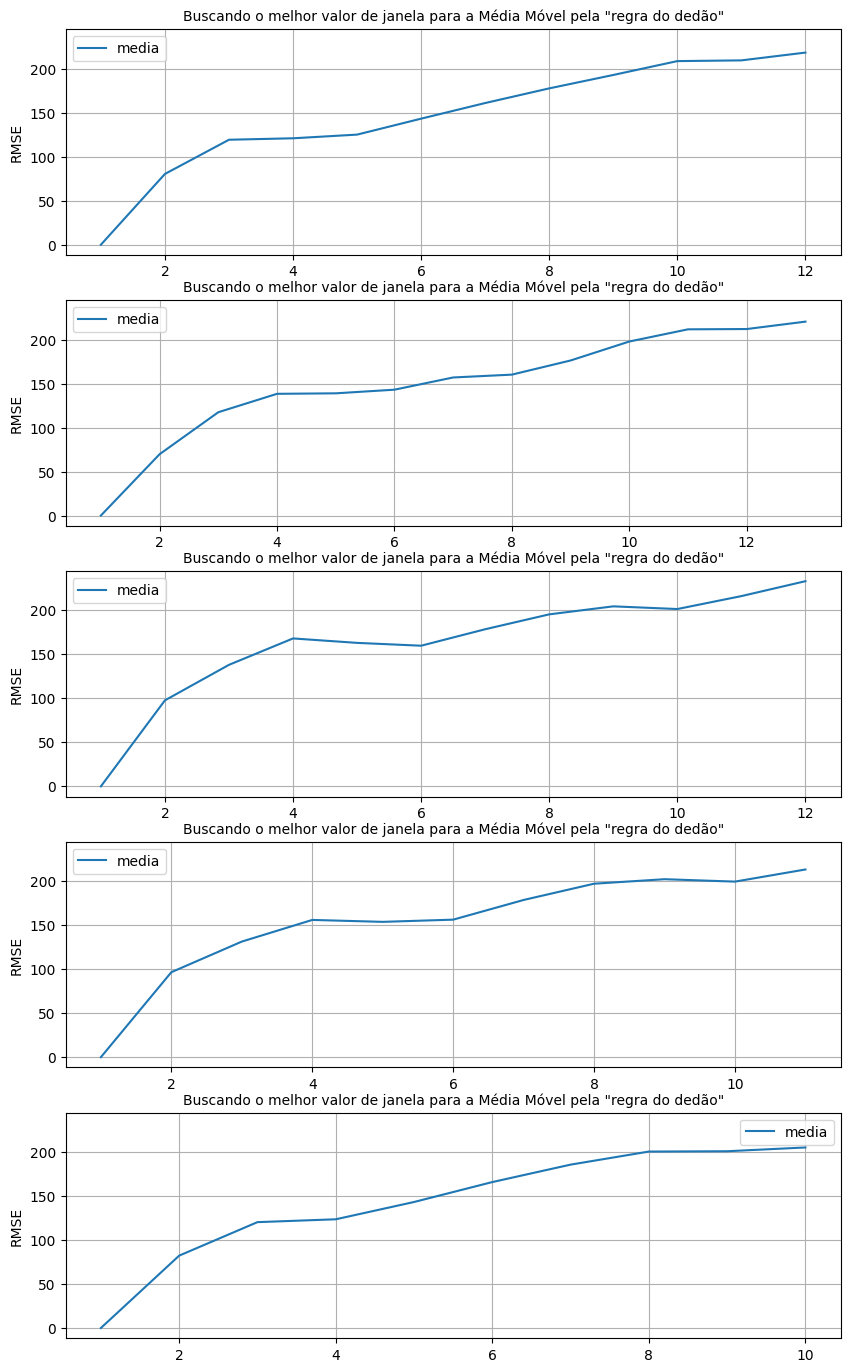

In [16]:
fig, ax = plt.subplots(nrows=5,figsize=(10,17), sharey = True)

for ind, weekday in enumerate([segundas, tercas, quartas, quintas, sextas]):

    erros_MA_diario = moving_average_test2(weekday)
    
    ax[ind].plot(erros_MA_diario.n_window, erros_MA_diario.RMSE)

    ax[ind].legend(loc= 'best',labels = ['media', 'mediana'])

    ax[ind].grid(visible=True, which = 'both')
    ax[ind].set_ylabel('RMSE')

    ax[ind].set_title('Buscando o melhor valor de janela para a Média Móvel pela "regra do dedão"', fontsize=10 )

plt.show()

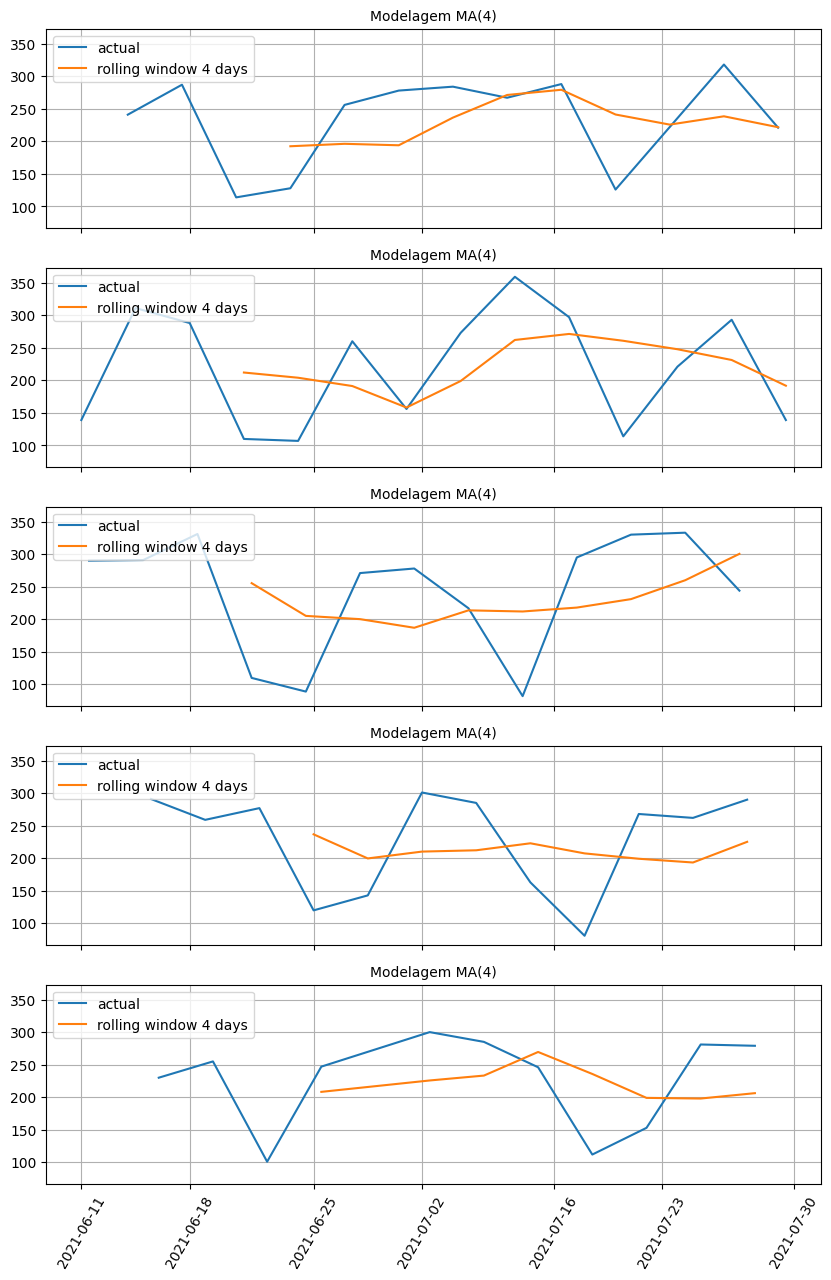

In [17]:
fig, ax = plt.subplots(nrows=5,figsize=(10,15), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    df['media_movel4'] = df['Volume'].rolling(4).mean()
    ax[idx].plot(df   .Data.dt.date, df   .Volume)
    ax[idx].plot(df   .Data.dt.date, df   .media_movel4)
    ax[idx].legend(loc = 'upper left', labels = ['actual', 'rolling window 4 days'])
    ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)
    ax[idx].set_title('Modelagem MA(4)', fontsize=10 )
    ax[idx].grid(visible=True, which = 'both')


    # ax[idx].set_title('')

plt.show()

#### Media Movel com step-by-step

In [18]:
segundas_MA =  segundas.iloc[:,:3] .copy()
tercas_MA =    tercas  .iloc[:,:3] .copy()
quartas_MA =   quartas .iloc[:,:3] .copy()
quintas_MA =   quintas .iloc[:,:3] .copy()
sextas_MA =    sextas  .iloc[:,:3] .copy()

dfs_MA = [segundas_MA, tercas_MA, quartas_MA, quintas_MA, sextas_MA]

for idx, df in enumerate(dfs_MA):
    results = list()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            MA_base = X['Volume'].rolling(4).mean().fillna(0)
            [results.append(MA_base.values[i]) for i in range(len(MA_base))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            MA_base = X['Volume'].rolling(4).mean()
            results.append(MA_base.values[-1])
    df = pd.concat([df,pd.Series(results, name = 'MA4')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_MA[idx] = df.copy()


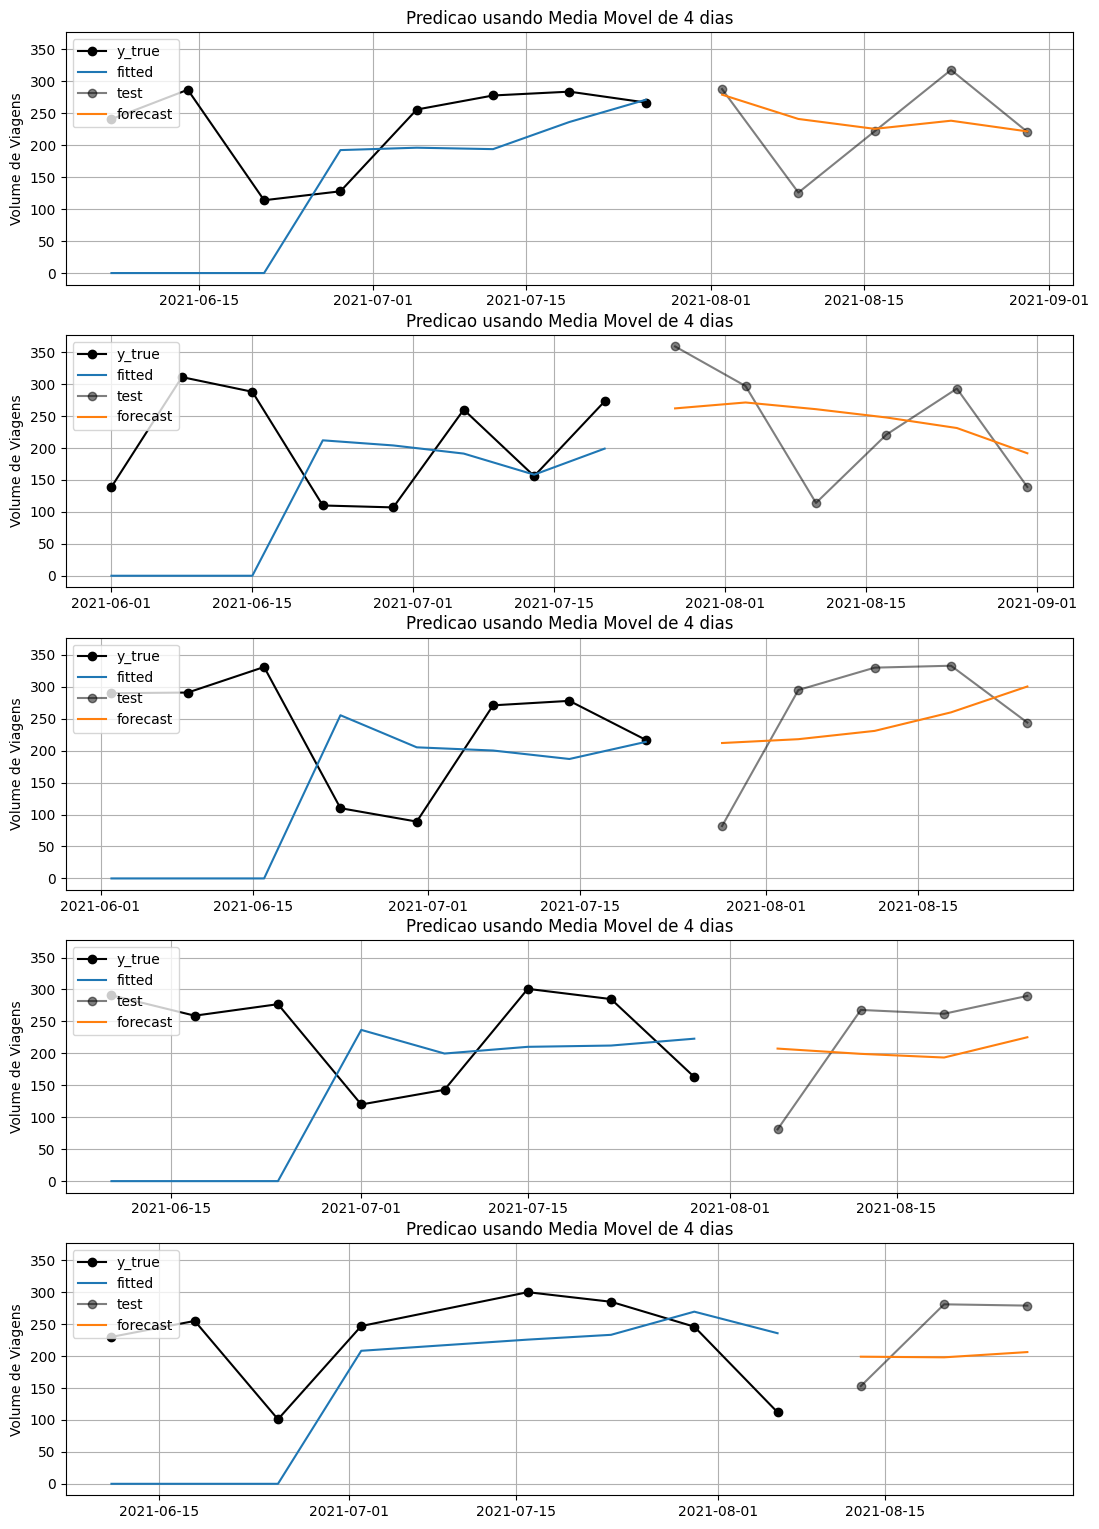

In [44]:
# plt.rcParams["figure.figsize"] = (10,15)

fig, ax = plt.subplots(nrows=5,figsize=(13,19), sharey = True)

for idx, df in enumerate(dfs_MA):

    # actual values
    ax[idx].plot(dfs_MA[idx]['Data'][:8],dfs_MA[idx]['y_true'][:8], marker="o", color="black")

    # result of trained values
    ax[idx].plot(dfs_MA[idx]['Data'][:8],dfs_MA[idx]['y_pred'][:8])

    # actual future values
    ax[idx].plot(dfs_MA[idx]['Data'][8:],dfs_MA[idx]['y_true'][8:], marker="o", color="black", alpha = 0.5)

    # predicted values
    ax[idx].plot(dfs_MA[idx]['Data'][8:],dfs_MA[idx]['y_pred'][8:])

    ax[idx].legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
    ax[idx].set_title('Predicao usando Media Movel de 4 dias', fontsize=12 )
    ax[idx].set_ylabel('Volume de Viagens')
    ax[idx].grid(visible=True, which = 'both')

plt.show()

### calculo do erro

In [20]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_MA):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_MA[idx]['y_true'][8:],
                                dfs_MA[idx]['y_pred'][8:],
                                squared=False))
    print('\t erro (MAE) da previsao \t',
            mean_absolute_error( dfs_MA[idx]['y_true'][8:],
                                dfs_MA[idx]['y_pred'][8:]))
    print('\t RMSE da média da previsao \t',
        mean_squared_error( dfs_MA[idx]['y_true'][8:],
                            [dfs_MA[idx]['y_true'].mean() for i in range(dfs_MA[idx]['y_true'][8:].shape[0])],
                            squared=False))


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 62.75985978314483
	 erro (MAE) da previsao 	 41.6
	 RMSE da média da previsao 	 66.27592492641706
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 80.53861651406734
	 erro (MAE) da previsao 	 68.45833333333333
	 RMSE da média da previsao 	 89.97542181402788
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 90.72072530574256
	 erro (MAE) da previsao 	 87.1
	 RMSE da média da previsao 	 94.09982738981458
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	 86.0430488186001
	 erro (M

## Suavizacao Exponencial


### Sem step-by-step

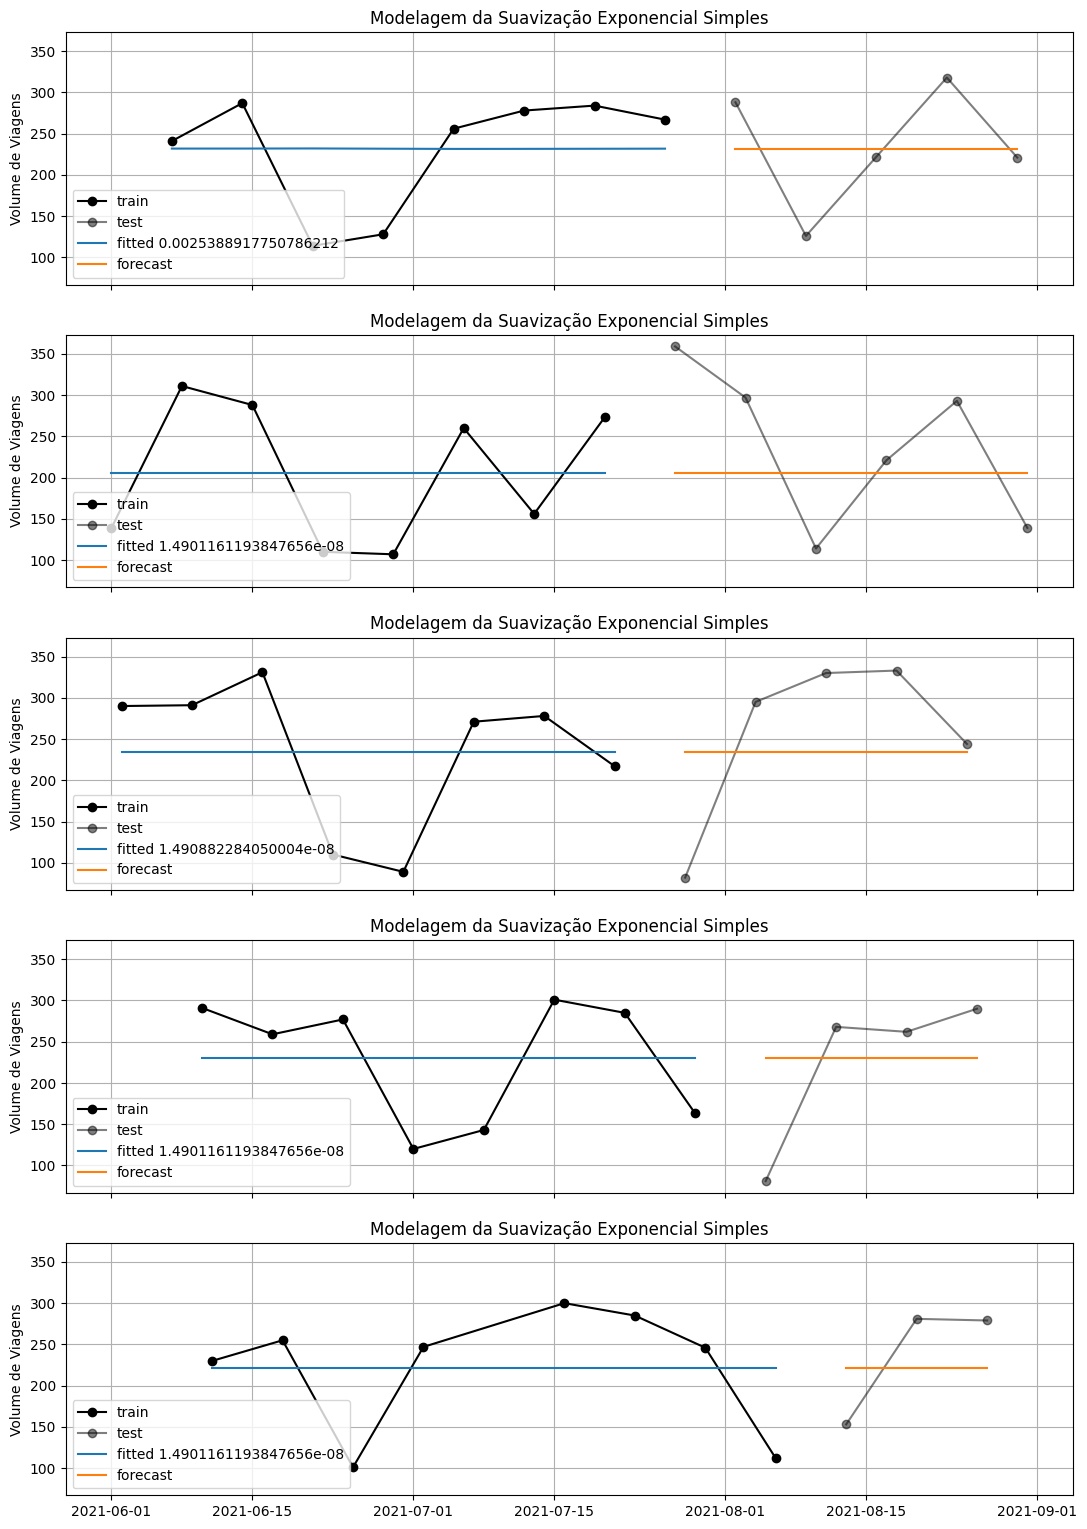

In [45]:

fig, ax = plt.subplots(nrows=5,figsize=(13,19), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    SES_diario = SimpleExpSmoothing(df['Volume'][:8].values, initialization_method="estimated").fit()

    ax[idx].plot(df['Data'][:8],df['Volume'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['Volume'][8:], marker="o", color="black", alpha = 0.5)
    ax[idx].plot(df['Data'][:8],SES_diario.fittedvalues)
    ax[idx].plot(df['Data'][8:],SES_diario.forecast(df['Volume'][8:].shape[0]))

    ax[idx].legend(loc = 'lower left', labels = ['train','test', 'fitted {}'.format(SES_diario.model.params["smoothing_level"]),  'forecast'])
    ax[idx].set_title('Modelagem da Suavização Exponencial Simples', fontsize=12 )
    ax[idx].set_ylabel('Volume de Viagens')
    ax[idx].grid(visible=True, which = 'both')


plt.show();

### Com step-by-step

In [22]:
segundas_SES =  segundas.iloc[:,:3] .copy()
tercas_SES =    tercas  .iloc[:,:3] .copy()
quartas_SES =   quartas .iloc[:,:3] .copy()
quintas_SES =   quintas .iloc[:,:3] .copy()
sextas_SES =    sextas  .iloc[:,:3] .copy()

dfs_SES = [segundas_SES, tercas_SES, quartas_SES, quintas_SES, sextas_SES]

for idx, df in enumerate(dfs_SES):

    results = list()
    df_results_SES = pd.DataFrame()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            SES_base = SimpleExpSmoothing(X['Volume'].values, initialization_method="estimated").fit()
            [results.append(SES_base.fittedvalues[i]) for i in range(len(SES_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            SES_base = SimpleExpSmoothing(X['Volume'].values, initialization_method="estimated").fit(smoothing_level=SES_base.model.params["smoothing_level"])
            results.append(SES_base.fittedvalues[-1])

    df = pd.concat([df,pd.Series(results, name = 'SES')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    print(idx, '-->','\t smoothing_level =',SES_base.model.params["smoothing_level"])
    display(df)
    dfs_SES[idx] = df.copy()


0 --> 	 smoothing_level = 0.0025388917750786212


DOW       Data  y_true      y_pred
0     0 2021-06-07     241  231.902454
1     0 2021-06-14     287  231.925552
2     0 2021-06-21     114  232.065380
3     0 2021-06-28     128  231.765625
4     0 2021-07-05     256  231.502175
5     0 2021-07-12     278  231.564372
6     0 2021-07-19     284  231.682267
7     0 2021-07-26     267  231.815096
8     0 2021-08-02     288  237.986542
9     0 2021-08-09     126  227.156934
10    0 2021-08-16     222  226.465880
11    0 2021-08-23     318  233.871810
12    0 2021-08-30     221  233.109249

1 --> 	 smoothing_level = 1.4901161193847656e-08


DOW       Data  y_true      y_pred
0     1 2021-06-01     139  205.500138
1     1 2021-06-08     311  205.500137
2     1 2021-06-15     288  205.500139
3     1 2021-06-22     110  205.500140
4     1 2021-06-29     107  205.500139
5     1 2021-07-06     260  205.500137
6     1 2021-07-13     156  205.500138
7     1 2021-07-20     273  205.500137
8     1 2021-07-27     359  222.555552
9     1 2021-08-03     297  229.999999
10    1 2021-08-10     114  219.454554
11    1 2021-08-17     221  219.583336
12    1 2021-08-24     293  225.230778
13    1 2021-08-31     139  219.071437

2 --> 	 smoothing_level = 1.490882284050004e-08


DOW       Data  y_true      y_pred
0     2 2021-06-02     290  234.624963
1     2 2021-06-09     291  234.624964
2     2 2021-06-16     331  234.624965
3     2 2021-06-23     110  234.624966
4     2 2021-06-30      89  234.624965
5     2 2021-07-07     271  234.624962
6     2 2021-07-14     278  234.624963
7     2 2021-07-21     217  234.624964
8     2 2021-07-28      82  217.666670
9     2 2021-08-04     295  225.399999
10    2 2021-08-11     330  234.909095
11    2 2021-08-18     333  243.083337
12    2 2021-08-25     244  243.153847

3 --> 	 smoothing_level = 1.4901161193847656e-08


DOW       Data  y_true      y_pred
0     3 2021-06-10     291  229.874982
1     3 2021-06-17     259  229.874983
2     3 2021-06-24     277  229.874983
3     3 2021-07-01     120  229.874984
4     3 2021-07-08     143  229.874983
5     3 2021-07-15     301  229.874981
6     3 2021-07-22     285  229.874982
7     3 2021-07-29     163  229.874983
8     3 2021-08-05      81  213.333336
9     3 2021-08-12     268  218.799999
10    3 2021-08-19     262  222.727272
11    3 2021-08-26     290  228.333337

4 --> 	 smoothing_level = 1.4901161193847656e-08


DOW       Data  y_true      y_pred
0     4 2021-06-11     230  221.999521
1     4 2021-06-18     255  221.999521
2     4 2021-06-25     101  221.999522
3     4 2021-07-02     247  221.999520
4     4 2021-07-16     300  221.999520
5     4 2021-07-23     285  221.999522
6     4 2021-07-30     246  221.999523
7     4 2021-08-06     112  221.999523
8     4 2021-08-13     153  214.333334
9     4 2021-08-20     281  220.999999
10    4 2021-08-27     279  226.272728

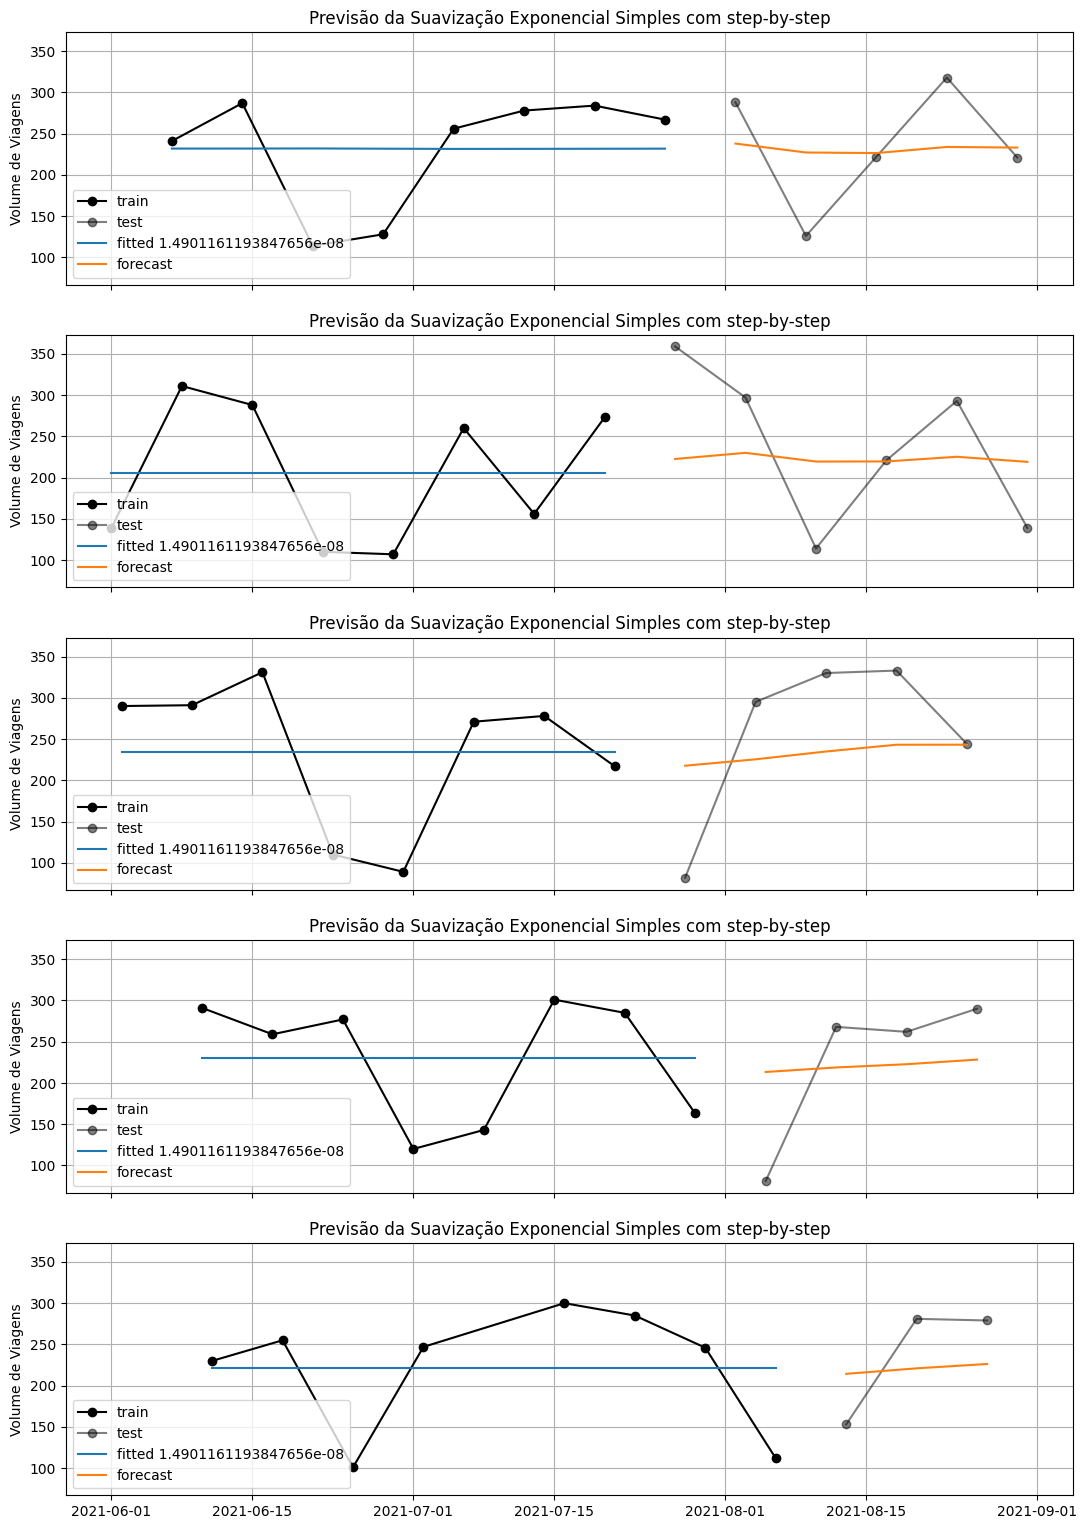

In [46]:

fig, ax = plt.subplots(nrows=5,figsize=(13,19), sharex= True, sharey = True)

for idx, df in enumerate(dfs_SES):

    ax[idx].plot(df['Data'][:8],df['y_true'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['y_true'][8:], marker="o", color="black", alpha = 0.5)
    ax[idx].plot(df['Data'][:8],df['y_pred'][:8])
    ax[idx].plot(df['Data'][8:],df['y_pred'][8:])

    ax[idx].legend(loc = 'lower left', labels = ['train','test', 'fitted {}'.format(SES_diario.model.params["smoothing_level"]),  'forecast'])
    ax[idx].set_title('Previsão da Suavização Exponencial Simples com step-by-step', fontsize=12 )
    ax[idx].set_ylabel('Volume de Viagens')
    ax[idx].grid(visible=True, which = 'both')


plt.show();

### calculo do erro

In [24]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_SES):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_SES[idx]['y_true'][8:],
                                dfs_SES[idx]['y_pred'][8:],
                                squared=False))
    print('\t erro (MAE) da previsao \t',
        mean_absolute_error( dfs_SES[idx]['y_true'][8:],
                            dfs_SES[idx]['y_pred'][8:]))
    print('\t RMSE da média da previsao \t',
            mean_squared_error( dfs_SES[idx]['y_true'][8:],
                                [dfs_SES[idx]['y_true'].mean() for i in range(dfs_SES[idx]['y_true'][8:].shape[0])],
                                squared=False))


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 63.21107770385413
	 erro (MAE) da previsao 	 50.37474227313926
	 RMSE da média da previsao 	 66.27592492641706
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 86.8263207393505
	 erro (MAE) da previsao 	 76.35938762437861
	 RMSE da média da previsao 	 89.97542181402788
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 89.86390597294309
	 erro (MAE) da previsao 	 78.22407849458688
	 RMSE da média da previsao 	 94.09982738981458
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	 7

## Metodo de Holt

### Escolha dos parametros

In [25]:
quartas[8:]

day_of_week       Data  Volume  media_movel4
8             2 2021-07-28      82         212.0
9             2 2021-08-04     295         218.0
10            2 2021-08-11     330         231.0
11            2 2021-08-18     333         260.0
12            2 2021-08-25     244         300.5

DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas

exponential, Type of trend component.
damped_trend, Should the trend component be damped.

================================================= errors day_of_week 0 =================================================

erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 62.02951688965107
erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 62.098498587244094
================================================= errors day_of_week 1 =================================================

erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 79.94030571343909
erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 139.6957929848433
================================================= errors day_of_week 2 =================================================

erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 80.77148217197264
erro (RMSE) da modelagem (fit otimiz

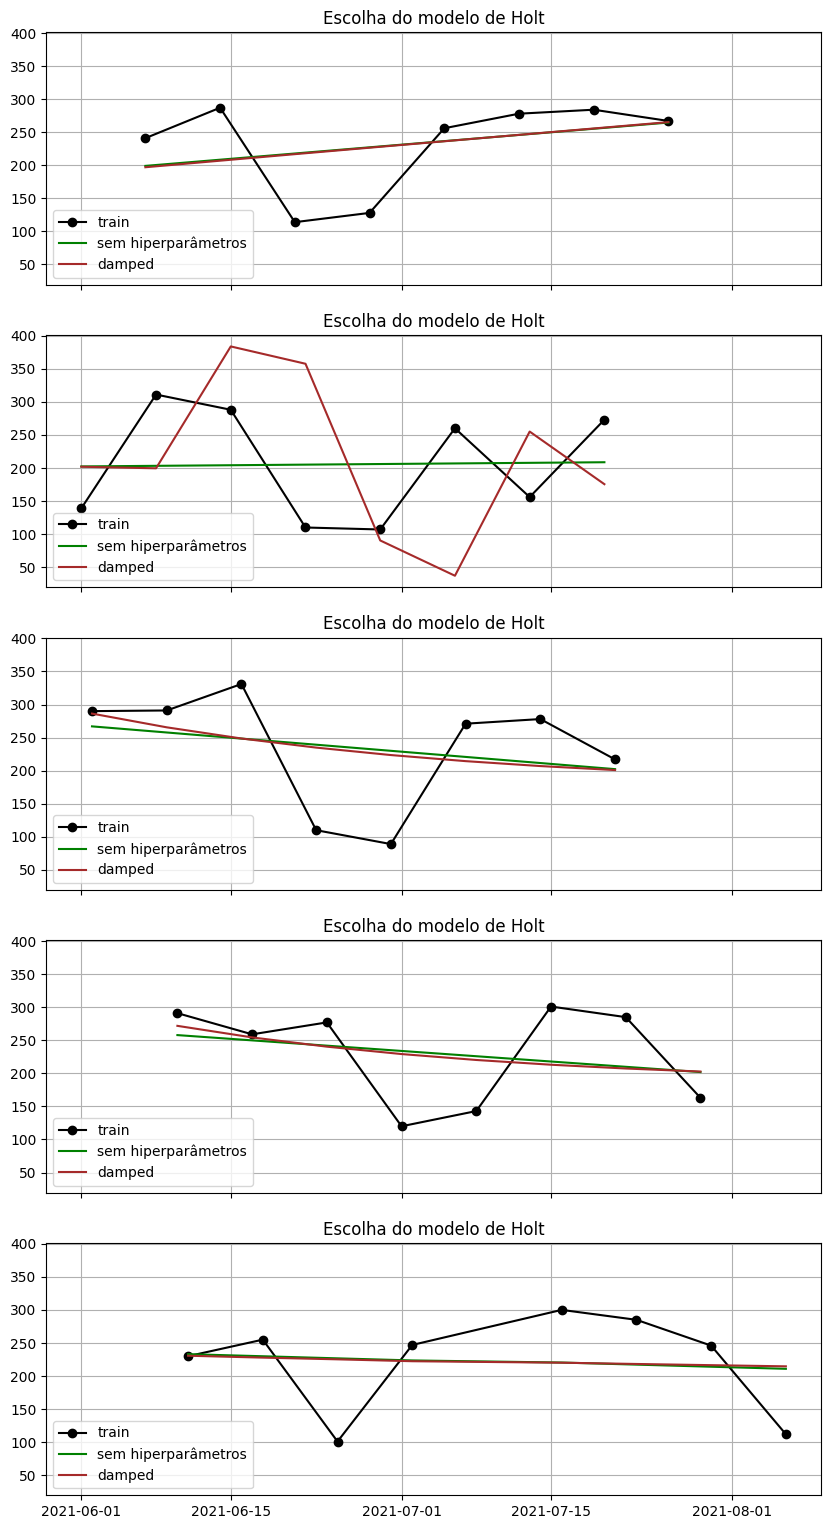

In [26]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas', end= '\n\n')

print('exponential, Type of trend component.', end= '\n')
print('damped_trend, Should the trend component be damped.', end= '\n\n')

fig, ax = plt.subplots(nrows=5,figsize=(10,19), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    Holt_diario1 = Holt(df['Volume'][:8].values, initialization_method="estimated").fit(optimized=True)
    # Holt_diario2 = Holt(df['Volume'][:8].values, exponential=True, initialization_method="estimated").fit(optimized=True)
    Holt_diario3 = Holt(df['Volume'][:8].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)
    # Holt_diario4 = Holt(df['Volume'][:8].values,exponential=True, damped_trend=True, initialization_method="estimated").fit(optimized=True)

    ax[idx].plot(df['Data'][:8],df['Volume'][:8], marker="o", color="black")
    # ax[idx].plot(df['Data'][8:],df['Volume'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],Holt_diario1.fittedvalues, color= 'green')
    # ax[idx].plot(df['Data'][:8],Holt_diario2.fittedvalues, color = 'orange')
    ax[idx].plot(df['Data'][:8],Holt_diario3.fittedvalues, color = 'brown')
    # ax[idx].plot(df['Data'][:8],Holt_diario4.fittedvalues, color = 'cyan')

    # ax[idx].plot(df['Data'][8:],Holt_diario1.forecast(df['Volume'][8:].shape[0]), color= 'green')
    # ax[idx].plot(df['Data'][8:],Holt_diario2.forecast(df['Volume'][8:].shape[0]), color = 'orange')
    # ax[idx].plot(df['Data'][8:],Holt_diario3.forecast(df['Volume'][8:].shape[0]), color = 'brown')
    # ax[idx].plot(df['Data'][8:],Holt_diario4.forecast(df['Volume'][8:].shape[0]), color = 'cyan')

    ax[idx].legend(loc = 'lower left', labels = [ 'train', 'sem hiperparâmetros','damped'])

    ax[idx].set_title('Escolha do modelo de Holt')
    ax[idx].grid(visible=True, which = 'both')

    print('=================================================',  'errors day_of_week',idx,'=================================================')

    print()
    print('erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)\t', mean_squared_error(df['Volume'][:8],Holt_diario1.fittedvalues, squared=False))
    # print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)\t', mean_squared_error(df['Volume'][:8],Holt_diario2.fittedvalues, squared=False))
    print('erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)\t', mean_squared_error(df['Volume'][:8],Holt_diario3.fittedvalues, squared=False))
    # print('erro (RMSE) da modelagem (fit otimizado = otimos / e=True e d=True)\t', mean_squared_error(df['Volume'][:8],Holt_diario4.fittedvalues, squared=False), end= '\n\n')

plt.show();

In [27]:
print('Resultados dos modelos para cada dia da semana\n')
print(''' 
DF0 = Segundas  erro (RMSE) da modelagem (fit otimizado = otimos / e=True e d=True)	 61.6662398734033

DF1 = Tercas    erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)	 79.9382023201059

DF2 = Quartas   erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 78.79010297363509

DF3 = Quintas   erro (RMSE) da modelagem (fit otimizado = otimos / e=True e d=True)	 65.82272847286823

DF4 = Sextas    erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 69.57624766281283
''')

Resultados dos modelos para cada dia da semana

 
DF0 = Segundas  erro (RMSE) da modelagem (fit otimizado = otimos / e=True e d=True)	 61.6662398734033

DF1 = Tercas    erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)	 79.9382023201059

DF2 = Quartas   erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 78.79010297363509

DF3 = Quintas   erro (RMSE) da modelagem (fit otimizado = otimos / e=True e d=True)	 65.82272847286823

DF4 = Sextas    erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 69.57624766281283



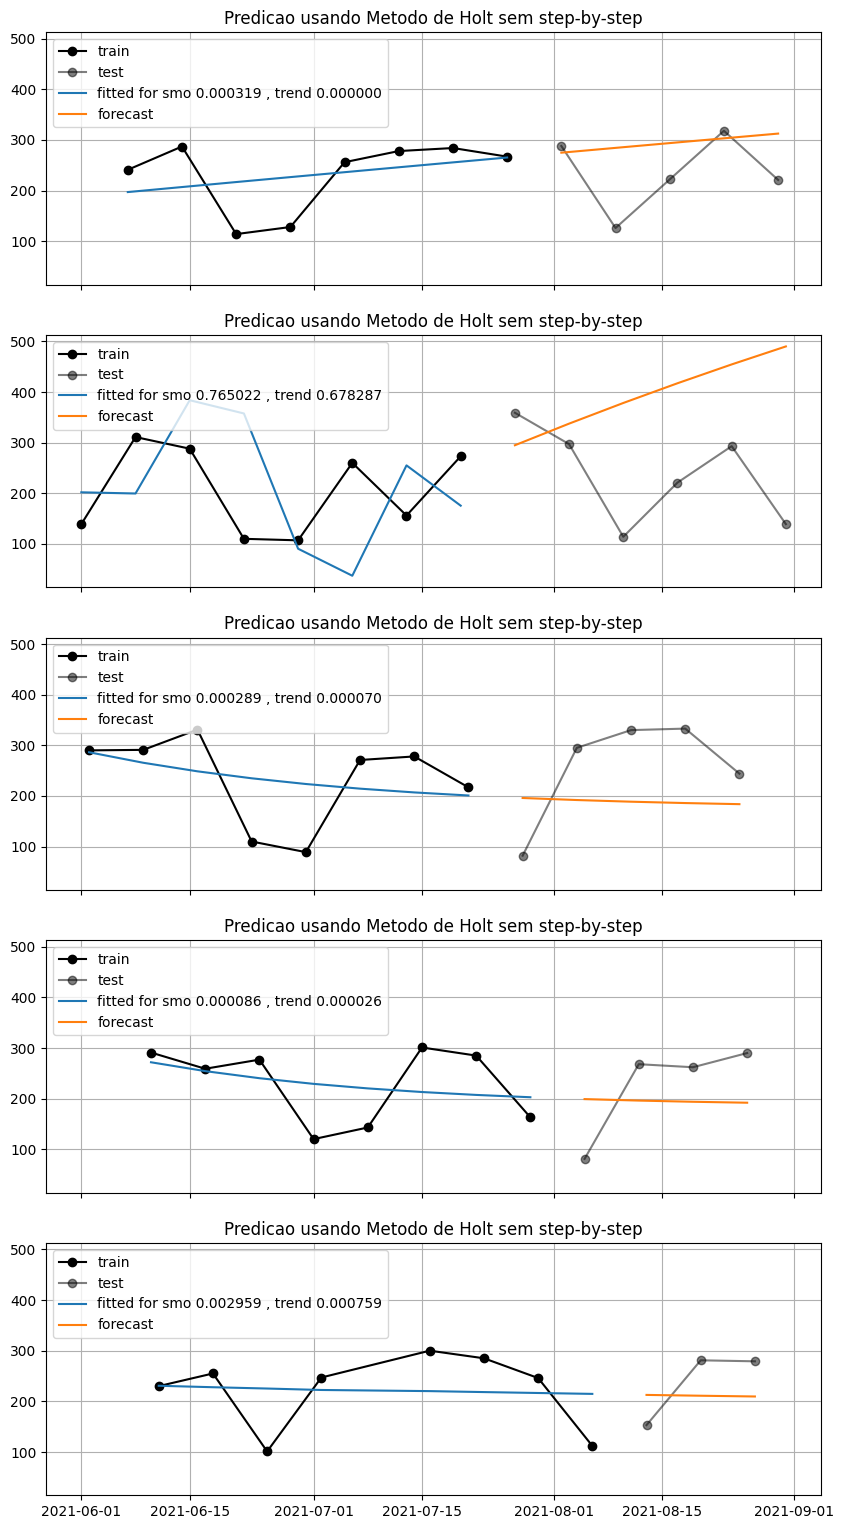

In [28]:
fig, ax = plt.subplots(nrows=5,figsize=(10,19), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    if idx == 0:
        Holt_diario = Holt(df['Volume'][:8].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

    elif idx == 1:
        Holt_diario = Holt(df['Volume'][:8].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

    elif idx == 2:
        Holt_diario = Holt(df['Volume'][:8].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

    elif idx == 3:
        Holt_diario = Holt(df['Volume'][:8].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

    elif idx == 4:
        Holt_diario = Holt(df['Volume'][:8].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

    ax[idx].plot(df['Data'][:8],df['Volume'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['Volume'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],Holt_diario.fittedvalues)

    ax[idx].plot(df['Data'][8:],Holt_diario.forecast(df['Volume'][8:].shape[0]))

    ax[idx].set_title('Predicao usando Metodo de Holt sem step-by-step')
    ax[idx].grid(visible=True, which = 'both')

    ax[idx].legend(loc = 'upper left', labels = ['train', 'test',
                    'fitted for smo {:f} , trend {:f}'.format(Holt_diario.model.params["smoothing_level"], Holt_diario.model.params["smoothing_trend"]),
                    'forecast'])

plt.show();


### Com step-by-step

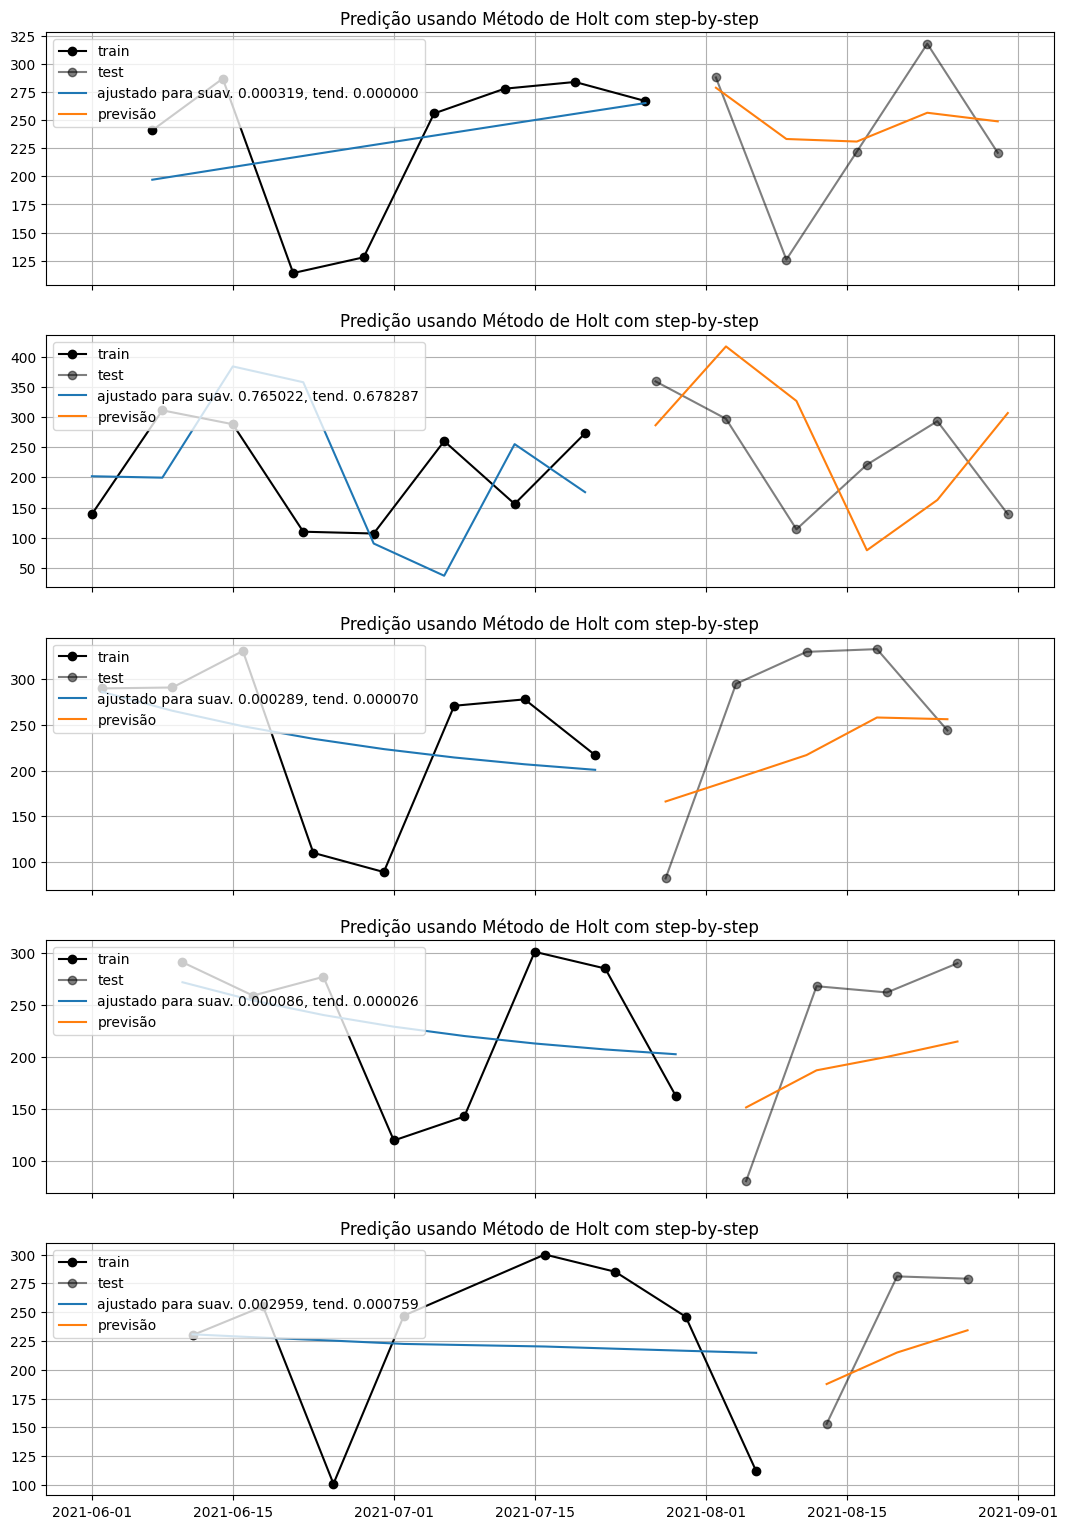

In [47]:
fig, ax = plt.subplots(nrows=5,figsize=(13,19), sharex= True)

segundas_SEH =  segundas.iloc[:,:3] .copy()
tercas_SEH =    tercas  .iloc[:,:3] .copy()
quartas_SEH =   quartas .iloc[:,:3] .copy()
quintas_SEH =   quintas .iloc[:,:3] .copy()
sextas_SEH =    sextas  .iloc[:,:3] .copy()

dfs_SEH = [segundas_SEH, tercas_SEH, quartas_SEH, quintas_SEH, sextas_SEH]

for idx, df in enumerate(dfs_SEH):

    results = list()
    df_results_SEH = pd.DataFrame()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            if idx == 0:
                H_base = Holt(X['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

            elif idx == 1:
                H_base = Holt(X['Volume'].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

            elif idx == 2:
                H_base = Holt(X['Volume'].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

            elif idx == 3:
                H_base = Holt(X['Volume'].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)

            elif idx == 4:
                H_base = Holt(X['Volume'].values,damped_trend=True, initialization_method="estimated").fit(optimized=True)
            [results.append(H_base.fittedvalues[i]) for i in range(len(H_base.fittedvalues))]

        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            if idx == 0:
                H_base = Holt(X['Volume'].values,damped_trend=True,
                                                initialization_method="estimated").fit(smoothing_level=H_base.model.params["smoothing_level"],
                                                                                                smoothing_trend=H_base.model.params["smoothing_trend"])

            elif idx == 1:
                H_base = Holt(X['Volume'].values,damped_trend=True, 
                                                initialization_method="estimated").fit(smoothing_level=H_base.model.params["smoothing_level"],
                                                                                                smoothing_trend=H_base.model.params["smoothing_trend"])

            elif idx == 2:
                H_base = Holt(X['Volume'].values,damped_trend=True, 
                                                initialization_method="estimated").fit(smoothing_level=H_base.model.params["smoothing_level"],
                                                                                                smoothing_trend=H_base.model.params["smoothing_trend"])

            elif idx == 3:
                H_base = Holt(X['Volume'].values,damped_trend=True, 
                                                initialization_method="estimated").fit(smoothing_level=H_base.model.params["smoothing_level"],
                                                                                                smoothing_trend=H_base.model.params["smoothing_trend"])

            elif idx == 4:
                H_base = Holt(X['Volume'].values,damped_trend=True,
                                                initialization_method="estimated").fit(smoothing_level=H_base.model.params["smoothing_level"],
                                                                                                smoothing_trend=H_base.model.params["smoothing_trend"])
            results.append(H_base.fittedvalues[-1])


    df = pd.concat([df,pd.Series(results, name = 'H')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_SEH[idx] = df.copy()


    ax[idx].plot(df['Data'][:8],df['y_true'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['y_true'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],df['y_pred'][:8])

    ax[idx].plot(df['Data'][8:],df['y_pred'][8:])


    ax[idx].set_title('Predição usando Método de Holt com step-by-step')
    ax[idx].grid(visible=True, which = 'both')

    ax[idx].legend(loc = 'upper left', labels = ['train', 'test',
                    'ajustado para suav. {:f}, tend. {:f}'.format(H_base.model.params["smoothing_level"], H_base.model.params["smoothing_trend"]),
                    'previsão'])

plt.show();


### calculo do erro

In [30]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_SEH):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_SEH[idx]['y_true'][8:],
                                dfs_SEH[idx]['y_pred'][8:],
                                squared=False))
    print('\t erro (MAE) da previsao \t',
        mean_absolute_error( dfs_SEH[idx]['y_true'][8:],
                            dfs_SEH[idx]['y_pred'][8:]))
    print('\t RMSE da média da previsao \t',
            mean_squared_error( dfs_SEH[idx]['y_true'][8:],
                                [dfs_SEH[idx]['y_true'].mean() for i in range(dfs_SEH[idx]['y_true'][8:].shape[0])],
                                squared=False))


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 56.95315698318435
	 erro (MAE) da previsao 	 42.94202649962109
	 RMSE da média da previsao 	 66.27592492641706
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 147.19341048640086
	 erro (MAE) da previsao 	 140.8035602756975
	 RMSE da média da previsao 	 89.97542181402788
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 85.24664701456521
	 erro (MAE) da previsao 	 77.57896333270915
	 RMSE da média da previsao 	 94.09982738981458
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	

## Metodo de Holt Winters

### escolha dos parametros

DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas

================================================= errors day_of_week 0 =================================================



Additive   Multiplicative     Additive Dam  \
$\alpha$          0.32321          0.39393          0.28786   
$\beta$           0.00010          0.39393          0.00010   
$\phi$            0.00000          0.00000          0.99000   
$\gamma$          0.00010          0.60607          0.00010   
$l_0$    13,727,427.06815 13,727,427.06815 13,727,427.06815   
$b_0$     3,378,990.41837  3,378,990.41837  3,378,990.41837   
RMSE             49.74064         61.26964         49.87446   

          Multiplicative Dam  
$\alpha$             0.39393  
$\beta$              0.39393  
$\phi$               0.99000  
$\gamma$             0.60607  
$l_0$       13,727,427.06815  
$b_0$        3,378,990.41837  
RMSE                61.26132

================================================= errors day_of_week 1 =================================================



Additive  Multiplicative  Additive Dam  Multiplicative Dam
$\alpha$   0.00000         0.00000       0.00000             0.00000
$\beta$    0.00000         0.00000       0.00000             0.00000
$\phi$     0.00000         0.00000       0.80000             0.80000
$\gamma$   0.00000         0.00000       0.00000             0.00000
$l_0$     18.46722        21.18386      19.32596            13.47669
$b_0$     -0.09687        -0.13283      -0.64630            -0.47168
RMSE      54.34521        54.10356      53.14352            52.86321

================================================= errors day_of_week 2 =================================================



Additive  Multiplicative  Additive Dam  Multiplicative Dam
$\alpha$      0.00500         0.00500       0.00500             0.00500
$\beta$       0.00010         0.00500       0.00010             0.00010
$\phi$        0.00000         0.00000       0.99000             0.99000
$\gamma$      0.99500         0.99500       0.99500             0.99500
$l_0$    28,147.66987    28,147.66987  28,147.66987        28,147.66987
$b_0$    -2,012.31767    -2,012.31767  -2,012.31767        -2,012.31767
RMSE        104.46782        74.46720     104.72954            74.17228

================================================= errors day_of_week 3 =================================================



Additive  Multiplicative  Additive Dam  Multiplicative Dam
$\alpha$      0.00500         0.00500       0.00500             0.00500
$\beta$       0.00010         0.00010       0.00010             0.00010
$\phi$        0.00000         0.00000       0.99000             0.99000
$\gamma$      0.99500         0.99500       0.99500             0.99500
$l_0$    23,487.92844    23,487.92844  23,487.92844        23,487.92844
$b_0$      -573.04022      -573.04022    -573.04022          -573.04022
RMSE         59.25355        54.84586      58.94279            54.82276

================================================= errors day_of_week 4 =================================================



Additive  Multiplicative  Additive Dam  Multiplicative Dam
$\alpha$      0.00500         0.00500       0.00500             0.00500
$\beta$       0.00010         0.00010       0.00010             0.00010
$\phi$        0.00000         0.00000       0.99000             0.99000
$\gamma$      0.99500         0.99500       0.99500             0.99500
$l_0$    94,454.46881    94,454.46881  94,454.46881        94,454.46881
$b_0$     8,054.68924     8,054.68924   8,054.68924         8,054.68924
RMSE         69.04908        77.53463      68.95835            77.29699

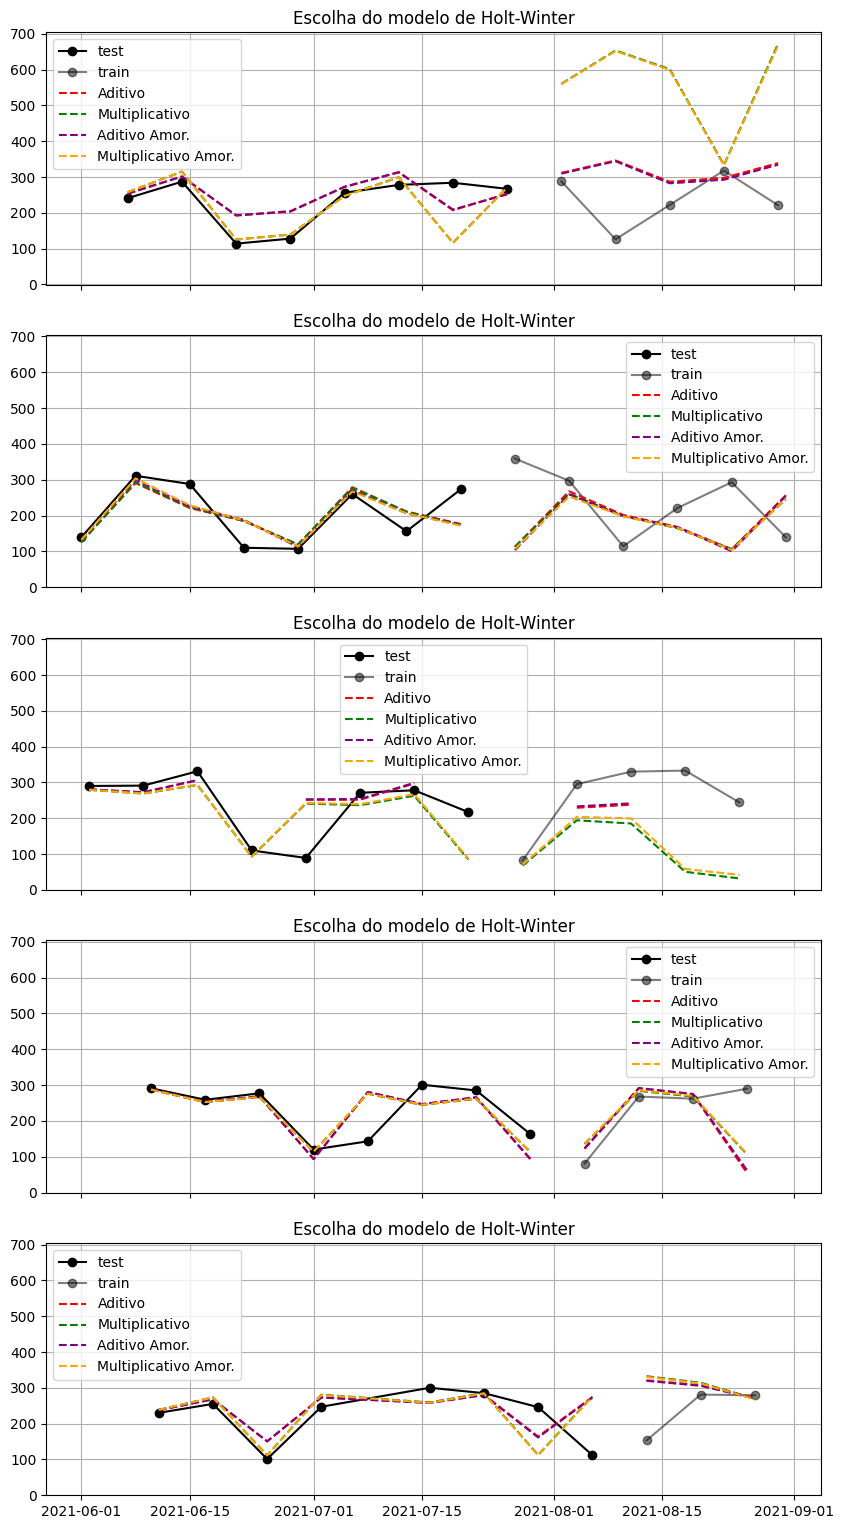

In [31]:
pd.options.display.float_format = '{:,.5f}'.format

print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas', end= '\n\n')


fig, ax = plt.subplots(nrows=5,figsize=(10,19), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    HW_diario1 = ExponentialSmoothing(df['Volume'][:8],seasonal_periods=4,trend="add",seasonal="add",use_boxcox=True,initialization_method="estimated").fit()
    HW_diario2 = ExponentialSmoothing(df['Volume'][:8],seasonal_periods=4,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit()
    HW_diario3 = ExponentialSmoothing(df['Volume'][:8],seasonal_periods=4,trend="add",seasonal="add",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()
    HW_diario4 = ExponentialSmoothing(df['Volume'][:8],seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

    erros_HW = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "RMSE"])
    params = ["smoothing_level","smoothing_trend","damping_trend","smoothing_seasonal","initial_level","initial_trend"]



    erros_HW["Additive"] = ([0 if math.isnan(HW_diario1.params[p]) else HW_diario1.params[p] for p in params] +          
                                                    [mean_squared_error(df['Volume'][:8],HW_diario1.fittedvalues.fillna(0), squared=False)])
    erros_HW["Multiplicative"] = ([0 if math.isnan(HW_diario2.params[p]) else HW_diario2.params[p] for p in params] +    
                                                    [mean_squared_error(df['Volume'][:8],HW_diario2.fittedvalues.fillna(0), squared=False)])
    erros_HW["Additive Dam"] = ([0 if math.isnan(HW_diario3.params[p]) else HW_diario3.params[p] for p in params] +      
                                                    [mean_squared_error(df['Volume'][:8],HW_diario3.fittedvalues.fillna(0), squared=False)])
    erros_HW["Multiplicative Dam"] = ([0 if math.isnan(HW_diario4.params[p]) else HW_diario4.params[p] for p in params] +
                                                    [mean_squared_error(df['Volume'][:8],HW_diario4.fittedvalues.fillna(0), squared=False)])


    ax[idx].plot(df['Data'][:8],df['Volume'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['Volume'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],HW_diario1.fittedvalues, linestyle="--", color=  'red')
    ax[idx].plot(df['Data'][:8],HW_diario2.fittedvalues, linestyle="--", color = 'green')
    ax[idx].plot(df['Data'][:8],HW_diario3.fittedvalues, linestyle="--", color = 'purple')
    ax[idx].plot(df['Data'][:8],HW_diario4.fittedvalues, linestyle="--", color = 'orange')

    ax[idx].plot(df['Data'][8:],HW_diario1.forecast(df['Volume'][8:].shape[0]), linestyle="--", color=  'red')
    ax[idx].plot(df['Data'][8:],HW_diario2.forecast(df['Volume'][8:].shape[0]), linestyle="--", color = 'green')
    ax[idx].plot(df['Data'][8:],HW_diario3.forecast(df['Volume'][8:].shape[0]), linestyle="--", color = 'purple')
    ax[idx].plot(df['Data'][8:],HW_diario4.forecast(df['Volume'][8:].shape[0]), linestyle="--", color = 'orange')

    ax[idx].legend(loc = 'best', labels = ['test', 'train','Aditivo','Multiplicativo', 'Aditivo Amor.', 'Multiplicativo Amor.'])

    ax[idx].set_title('Escolha do modelo de Holt-Winter')
    ax[idx].grid(visible=True)

    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print()
    display(erros_HW)

plt.show();

In [32]:
print('Resultados dos modelos para cada dia da semana\n')
print(''' 
DF0 = Segundas  erro (RMSE) da modelagem (Additive / trend="add",seasonal="add")                                49.74064

DF1 = Tercas    erro (RMSE) da modelagem (Multiplicative Dam / trend="add",seasonal="mul",damped_trend=True)    52.86321

DF2 = Quartas   erro (RMSE) da modelagem (Multiplicative Dam / trend="add",seasonal="mul",damped_trend=True)    74.17228

DF3 = Quintas   erro (RMSE) da modelagem (Multiplicative Dam / trend="add",seasonal="mul",damped_trend=True)    54.82276

DF4 = Sextas    erro (RMSE) da modelagem (Additive Dam / trend="add",seasonal="add",damped_trend=True)	        68.95835
''')

Resultados dos modelos para cada dia da semana

 
DF0 = Segundas  erro (RMSE) da modelagem (Additive / trend="add",seasonal="add")                                49.74064

DF1 = Tercas    erro (RMSE) da modelagem (Multiplicative Dam / trend="add",seasonal="mul",damped_trend=True)    52.86321

DF2 = Quartas   erro (RMSE) da modelagem (Multiplicative Dam / trend="add",seasonal="mul",damped_trend=True)    74.17228

DF3 = Quintas   erro (RMSE) da modelagem (Multiplicative Dam / trend="add",seasonal="mul",damped_trend=True)    54.82276

DF4 = Sextas    erro (RMSE) da modelagem (Additive Dam / trend="add",seasonal="add",damped_trend=True)	        68.95835



### Com step-by-step

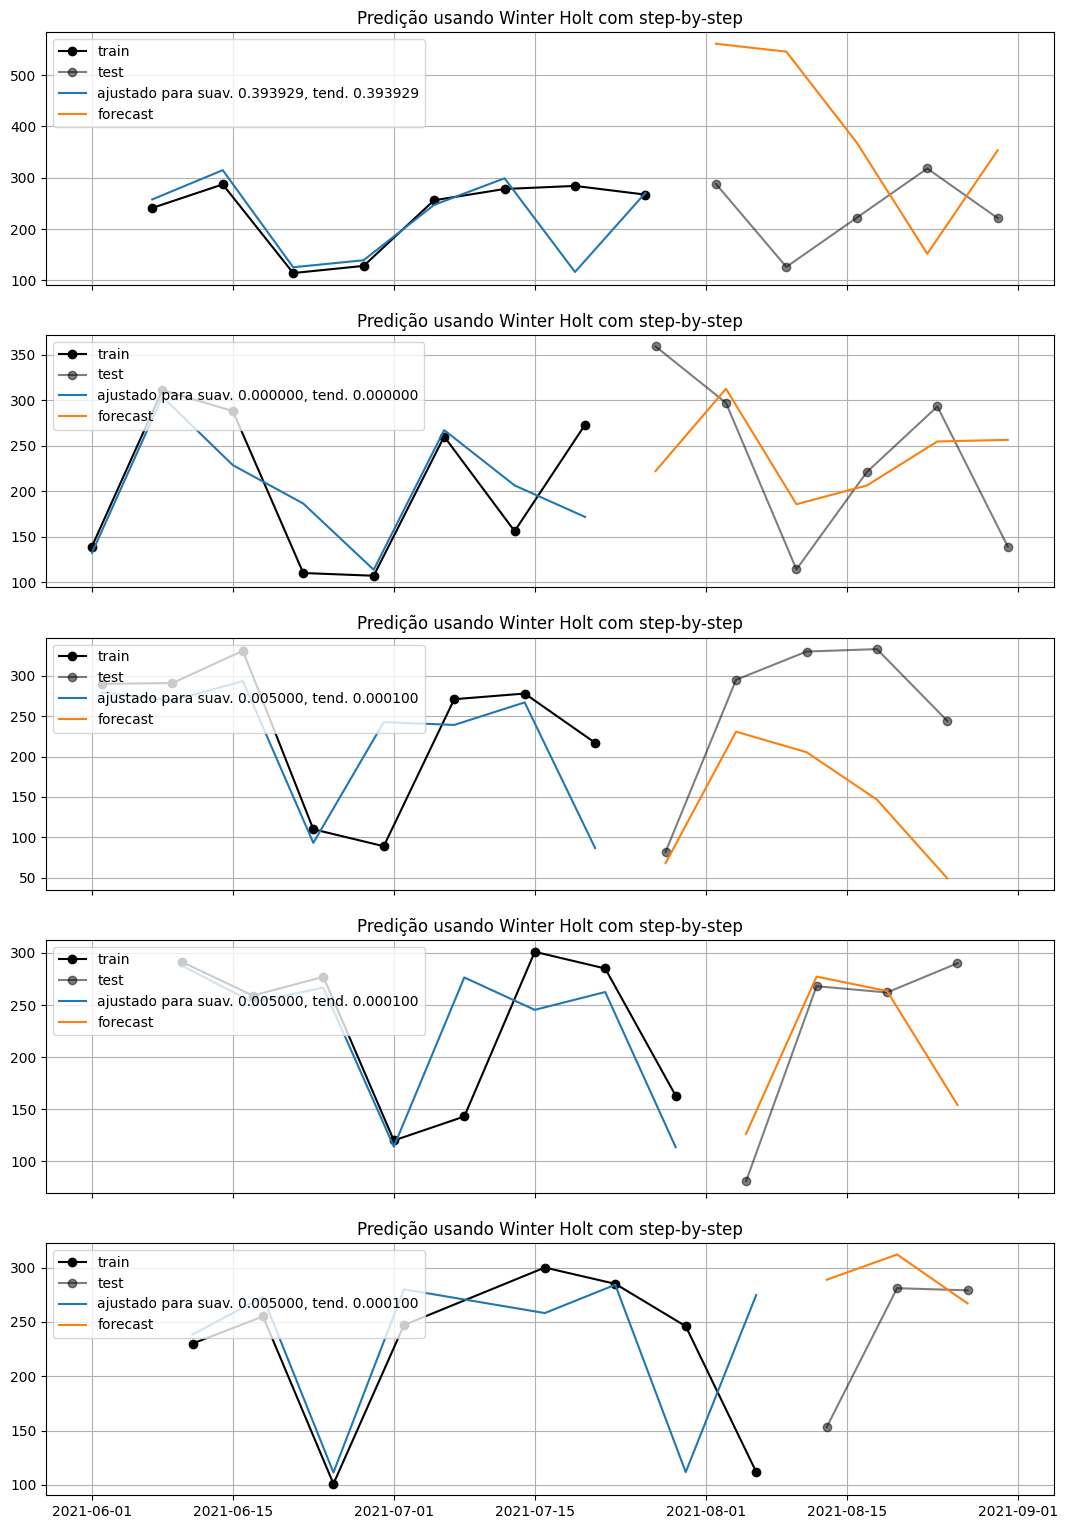

In [48]:
fig, ax = plt.subplots(nrows=5,figsize=(13,19), sharex= True)

segundas_HW =   segundas.iloc[:,:3] .copy()
tercas_HW =     tercas  .iloc[:,:3] .copy()
quartas_HW =    quartas .iloc[:,:3] .copy()
quintas_HW =    quintas .iloc[:,:3] .copy()
sextas_HW =     sextas  .iloc[:,:3] .copy()

dfs_HW = [segundas_HW, tercas_HW, quartas_HW, quintas_HW, sextas_HW]

for idx, df in enumerate(dfs_HW):

    results = list()
    df_results_HW = pd.DataFrame()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            if idx == 0:
                HW_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,
                                                                        use_boxcox=True,initialization_method="estimated").fit()

            elif (idx == 1) | (idx == 2) | (idx == 3):
                HW_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,
                                                                        use_boxcox=True,initialization_method="estimated").fit()

            elif idx == 4:
                HW_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,
                                                                        use_boxcox=True,initialization_method="estimated").fit()

            [results.append(HW_base.fittedvalues[i]) for i in range(len(HW_base.fittedvalues))]

        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            if idx == 0:
                HW_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,
                                                initialization_method="estimated").fit( smoothing_level=HW_base.model.params["smoothing_level"],
                                                                                        smoothing_trend=HW_base.model.params["smoothing_trend"], 
                                                                                        smoothing_seasonal=HW_base.model.params["smoothing_seasonal"], 
                                                                                        damping_trend=HW_base.model.params["damping_trend"])

            elif (idx == 1) | (idx == 2) | (idx == 3):
                HW_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,
                                                initialization_method="estimated").fit( smoothing_level=HW_base.model.params["smoothing_level"],
                                                                                        smoothing_trend=HW_base.model.params["smoothing_trend"], 
                                                                                        smoothing_seasonal=HW_base.model.params["smoothing_seasonal"], 
                                                                                        damping_trend=HW_base.model.params["damping_trend"])


            elif idx == 4:
                HW_base = ExponentialSmoothing(X['Volume'].values,seasonal_periods=4,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,
                                                initialization_method="estimated").fit( smoothing_level=HW_base.model.params["smoothing_level"],
                                                                                        smoothing_trend=HW_base.model.params["smoothing_trend"], 
                                                                                        smoothing_seasonal=HW_base.model.params["smoothing_seasonal"], 
                                                                                        damping_trend=HW_base.model.params["damping_trend"])
            results.append(HW_base.fittedvalues[-1])


    df = pd.concat([df,pd.Series(results, name = 'H')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_HW[idx] = df.copy()

    ax[idx].plot(df['Data'][:8],df['y_true'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['y_true'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],df['y_pred'][:8])

    ax[idx].plot(df['Data'][8:],df['y_pred'][8:])


    ax[idx].set_title('Predição usando Winter Holt com step-by-step')
    ax[idx].grid(visible=True)
    ax[idx].legend(loc = 'upper left', labels = ['train', 'test',
                    'ajustado para suav. {:f}, tend. {:f}'.format(HW_base.model.params["smoothing_level"], HW_base.model.params["smoothing_trend"]),
                    'forecast'])

plt.show();


### calculo do erro

In [34]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_HW):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_HW[idx]['y_true'][8:],
                                dfs_HW[idx]['y_pred'][8:],
                                squared=False))
    print('\t erro (MAE) da previsao \t',
        mean_absolute_error( dfs_HW[idx]['y_true'][8:],
                            dfs_HW[idx]['y_pred'][8:]))
    print('\t RMSE da média da previsao \t',
            mean_squared_error( dfs_HW[idx]['y_true'][8:],
                                [dfs_HW[idx]['y_true'].mean() for i in range(dfs_HW[idx]['y_true'][8:].shape[0])],
                                squared=False))


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 252.0653176418258
	 erro (MAE) da previsao 	 227.7065040944969
	 RMSE da média da previsao 	 66.27592492641706
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 81.23404071315346
	 erro (MAE) da previsao 	 65.76617877817635
	 RMSE da média da previsao 	 89.97542181402788
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 136.0461632536847
	 erro (MAE) da previsao 	 116.78686580171923
	 RMSE da média da previsao 	 94.09982738981458
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	

## ARIMA


### Determinação dos parâmetros do ARIMA

#### Checar se a série é estacionária
A série estacionária é condição _sine qua non_ para a aplicação do método; caso nao for, é possível utilizar a diferenciação da série - quantas vezes forem necessárias -  para torná-la estacionária. Escolhido o radar, observa-se se a série pode ser considerada estacionária (p-value inferior a 0.05) por meio do teste de Dickey-Fuller aumentado (ADF).

In [35]:
segundas_ARIMA =   segundas.iloc[:,:3] .copy()
tercas_ARIMA =     tercas  .iloc[:,:3] .copy()
quartas_ARIMA =    quartas .iloc[:,:3] .copy()
quintas_ARIMA =    quintas .iloc[:,:3] .copy()
sextas_ARIMA =     sextas  .iloc[:,:3] .copy()

dfs_ARIMA = [segundas_ARIMA, tercas_ARIMA, quartas_ARIMA, quintas_ARIMA, sextas_ARIMA]


for idx, df in enumerate(dfs_ARIMA):

    print('=================================================', 'adfuller day_of_week',idx,'=================================================')

    result_adfuller = adfuller(df.Volume)
    print('ADF Statistic: %f' % result_adfuller[0])
    print('p-value: %f' % result_adfuller[1])

================================================= adfuller day_of_week 0 =================================================
ADF Statistic: -2.671017
p-value: 0.079189
================================================= adfuller day_of_week 1 =================================================
ADF Statistic: -2.656224
p-value: 0.081925
================================================= adfuller day_of_week 2 =================================================
ADF Statistic: 1.377425
p-value: 0.997009
================================================= adfuller day_of_week 3 =================================================
ADF Statistic: -0.112935
p-value: 0.948135
================================================= adfuller day_of_week 4 =================================================
ADF Statistic: -3.193874
p-value: 0.020342


#### Validação Visual

Para validar visualmente o resultado do teste ADF, plotamos funções de autocorrelação para a série original, com diferenciação de primeira e de segunda ordem. 

Espera-se que a série original tenha uma curva da Função de Autocorrelação (ACF) decrescente enquanto as outras possuam uma queda abrupta pois, segundo o teste ADF, elas já serão diferenciadas.

==================================================== ACF day_of_week 0 ====================================================


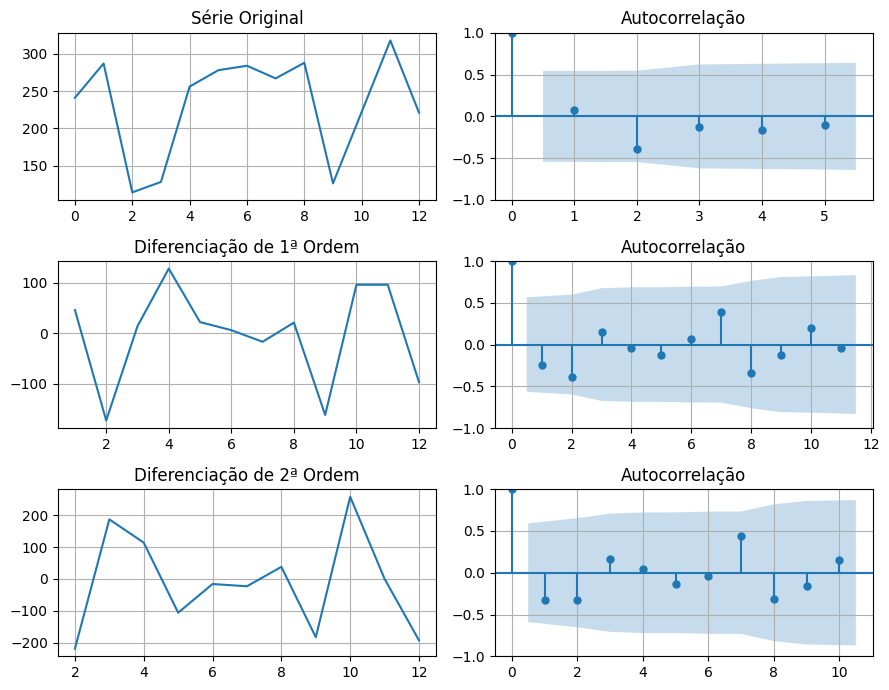

==================================================== ACF day_of_week 1 ====================================================


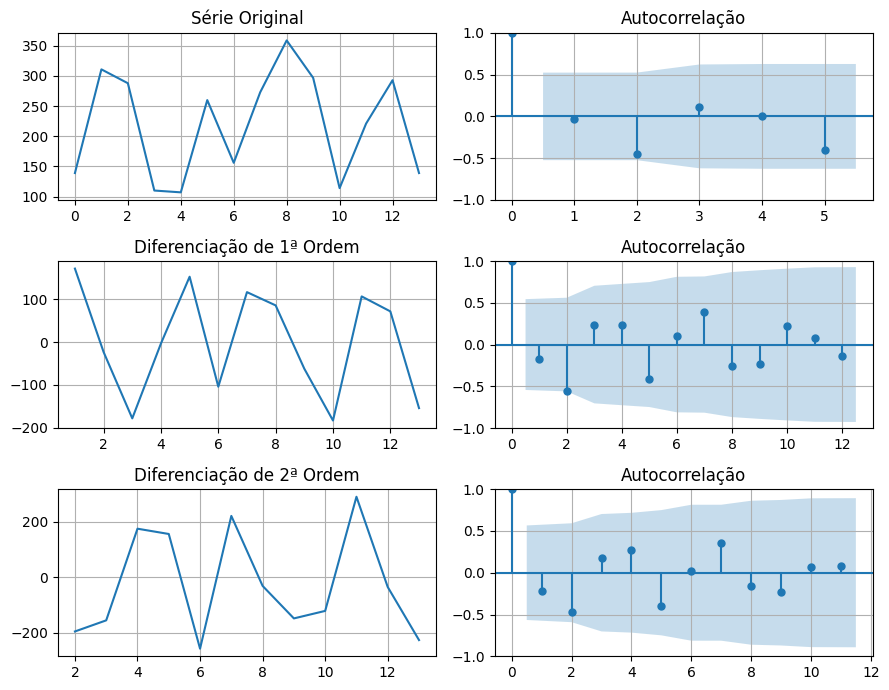

==================================================== ACF day_of_week 2 ====================================================


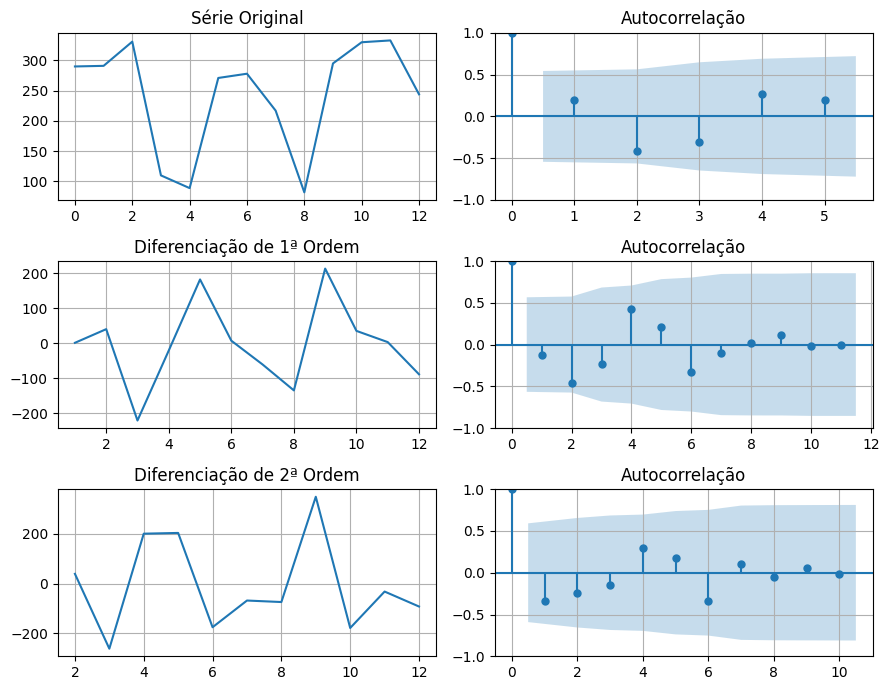

==================================================== ACF day_of_week 3 ====================================================


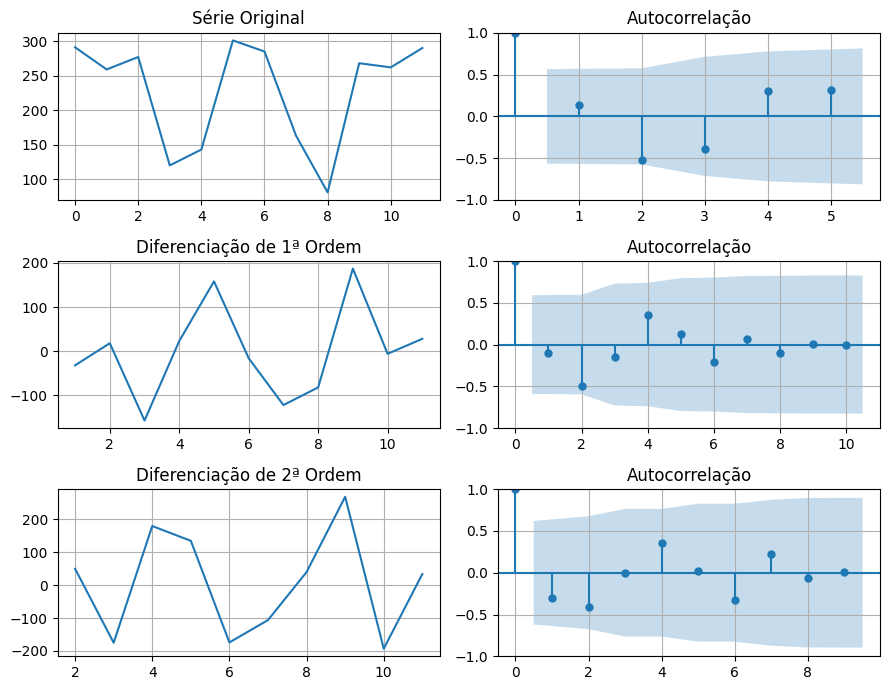

==================================================== ACF day_of_week 4 ====================================================


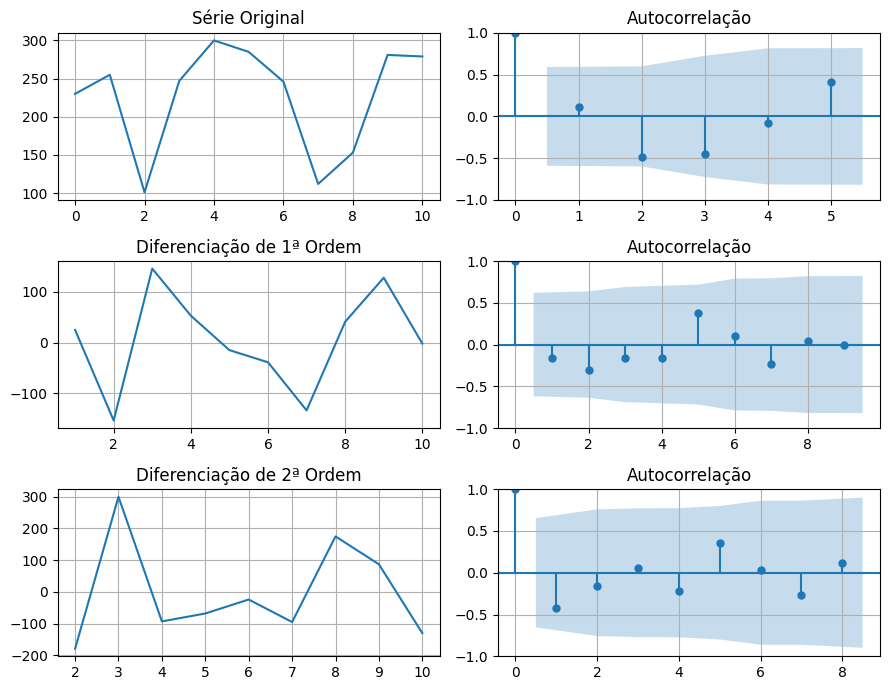

In [36]:
for idx, df in enumerate(dfs_ARIMA):

    print('====================================================', 'ACF day_of_week',idx, '====================================================')

    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})
    fig, axes = plt.subplots(3, 2, sharex=False)

    # Original Series
    axes[0, 0].plot(df.Volume); axes[0, 0].set_title('Série Original')
    plot_acf(df.Volume, ax=axes[0, 1], alpha=0.05, lags=5, title='Autocorrelação')

    # 1st Differencing
    axes[1, 0].plot(df.Volume.diff()); axes[1, 0].set_title('Diferenciação de 1ª Ordem')
    plot_acf(df.Volume.diff().dropna(), ax=axes[1, 1], title='Autocorrelação')

    # 2nd Differencing
    axes[2, 0].plot(df.Volume.diff().diff()); axes[2, 0].set_title('Diferenciação de 2ª Ordem')
    plot_acf(df.Volume.diff().diff().dropna(), ax=axes[2, 1], title='Autocorrelação')
    axes[0,0].grid(visible=True),axes[0,1].grid(visible=True),axes[1,0].grid(visible=True),axes[1,1].grid(visible=True),axes[2,0].grid(visible=True),axes[2,1].grid(visible=True)

    plt.tight_layout()
    plt.show()

Os graficos mostram que na primeira diferenciação a série já se torna super diferenciada (o que pode ser notado pela queda abrupta na curva de autocorrelação). Isso indica que o parâmetro d=1 é o ideal para todos os casos

#### Ordem da Auto-Regressão

Por se tratar de uma regressão feita sobre os valores anteriores da série vale conferir até que ponto há correlação entre os pontos de observação. Isso é definido através da Função de Autocorrelação Parcial (PACF).

============================================ PACF day_of_week 0 ============================================


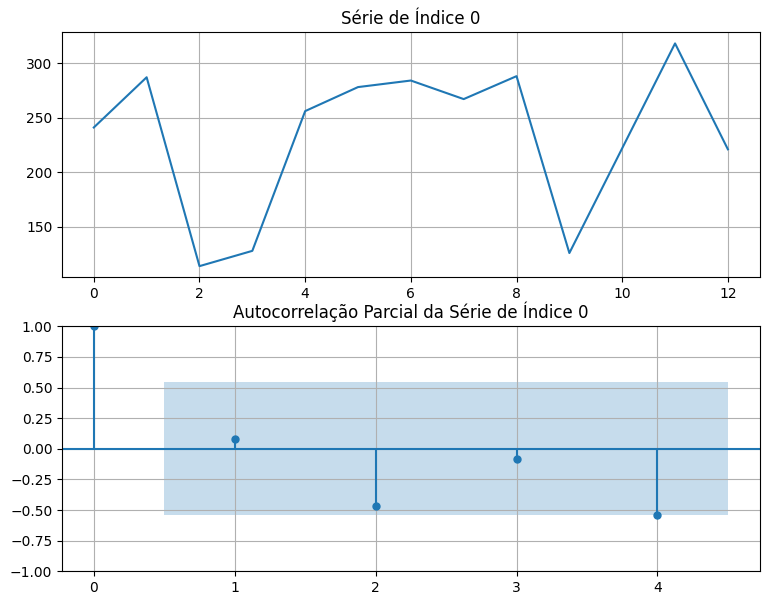

============================================ PACF day_of_week 1 ============================================


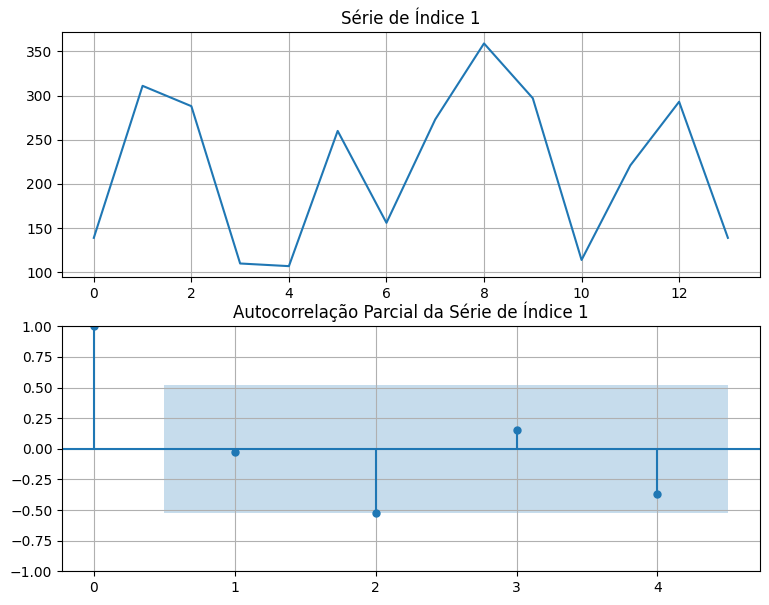

============================================ PACF day_of_week 2 ============================================


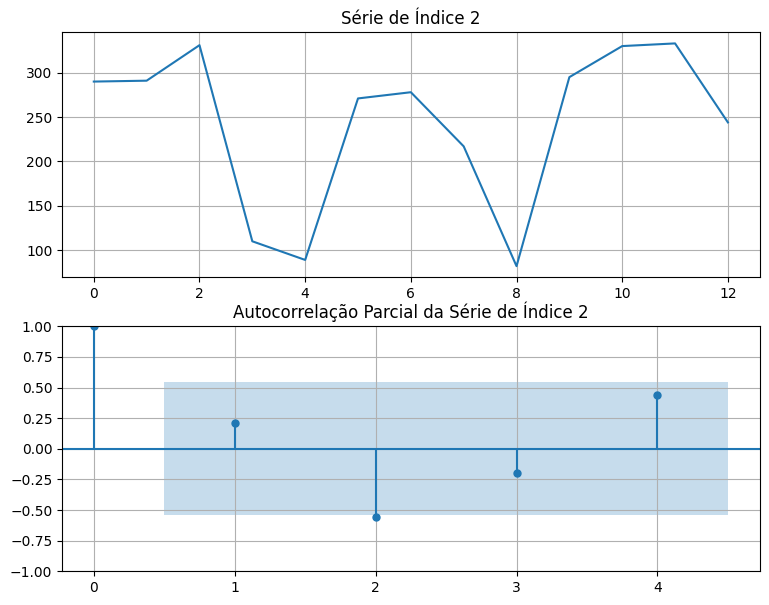

============================================ PACF day_of_week 3 ============================================


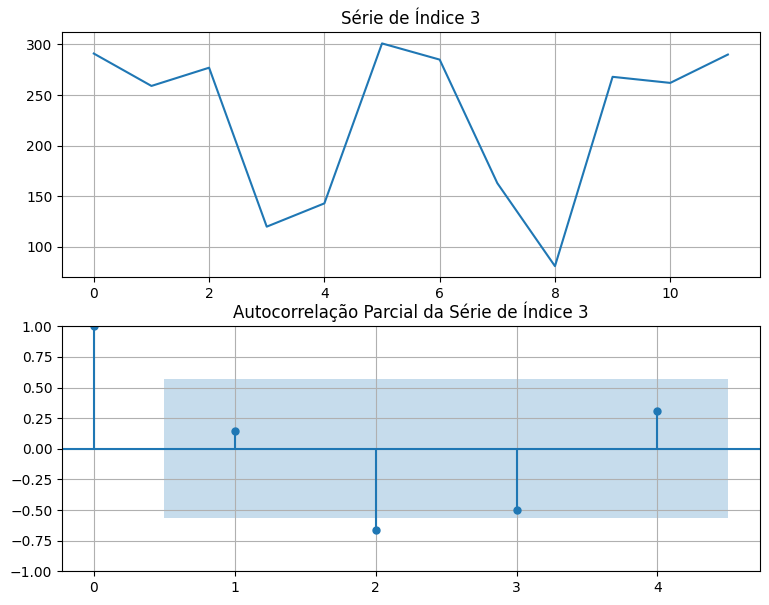

============================================ PACF day_of_week 4 ============================================


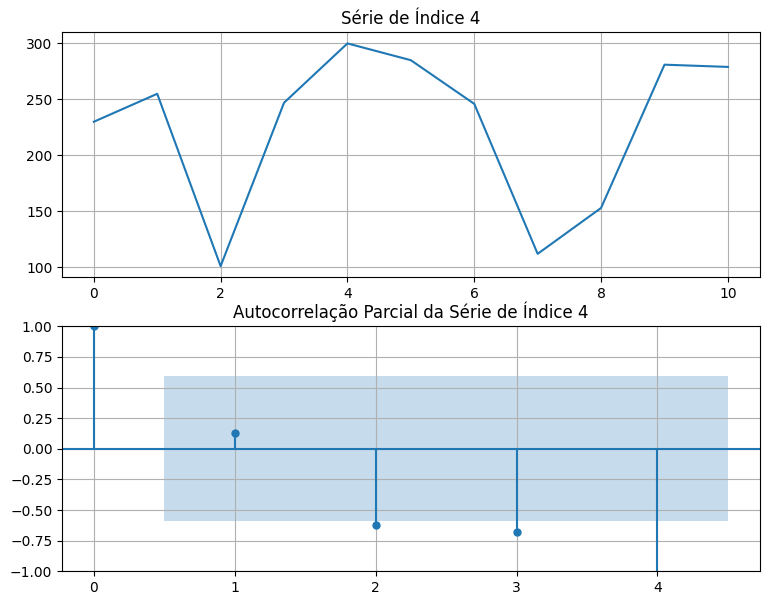

In [37]:
# PACF
for idx, df in enumerate(dfs_ARIMA):

    print('============================================', 'PACF day_of_week',idx, '============================================')

    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})
    fig, axes = plt.subplots(2, 1, sharex=False)
    axes[0].plot(df.Volume); axes[0].set_title('Série de Índice {}'.format(idx))

    axes[1].set(ylim=(0,1.5))
    plot_pacf(df.Volume, ax=axes[1], lags= 4, title='Autocorrelação Parcial da Série de Índice {}'.format(idx))
    axes[0].grid(visible=True),axes[1].grid(visible=True)
    plt.show()

#### Ordem da Média-Móvel

O plot da ACF fornece um threshold, um limite, superior para o ordem do modelo MA. 

============================================ ACF day_of_week 0 ============================================


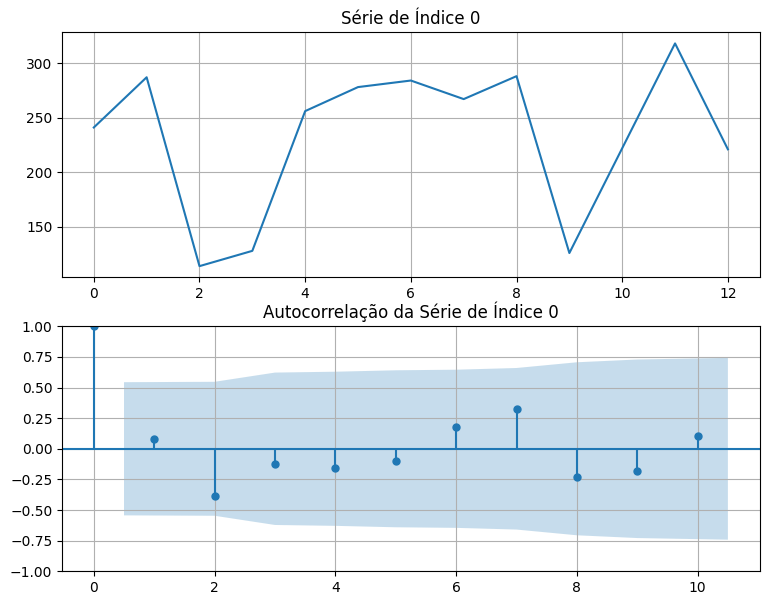

============================================ ACF day_of_week 1 ============================================


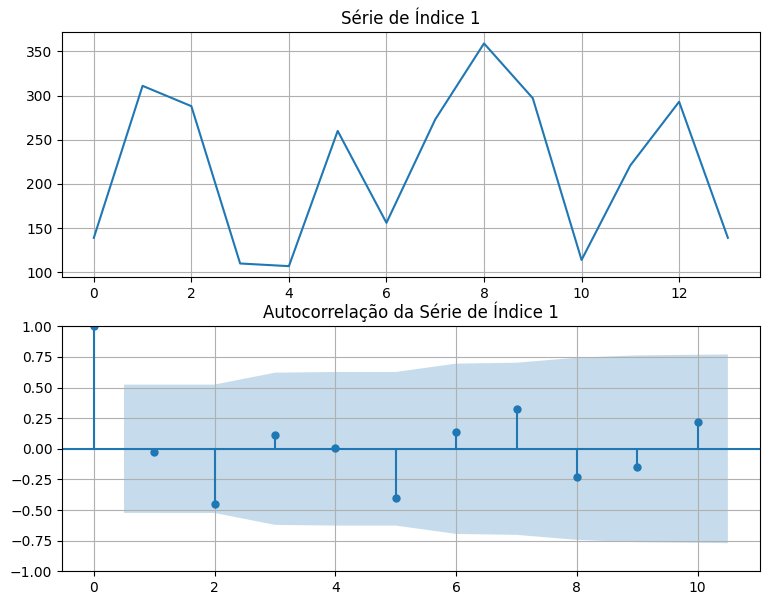

============================================ ACF day_of_week 2 ============================================


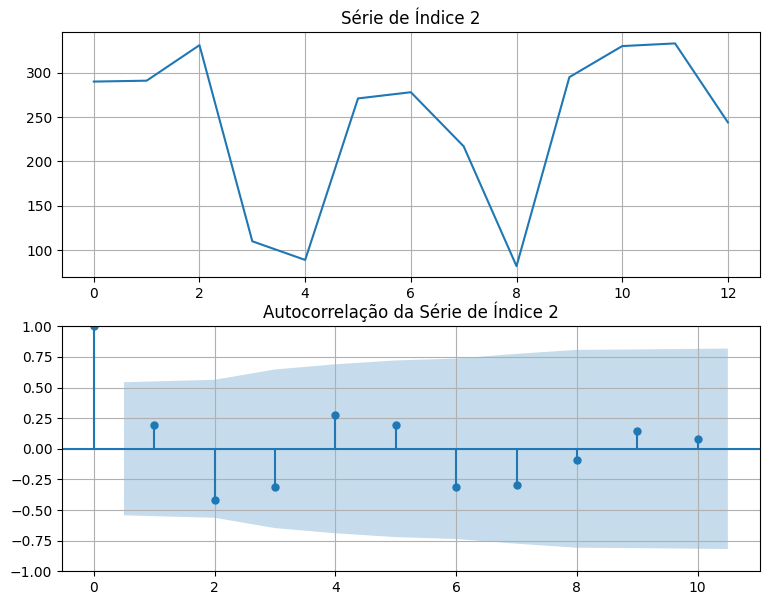

============================================ ACF day_of_week 3 ============================================


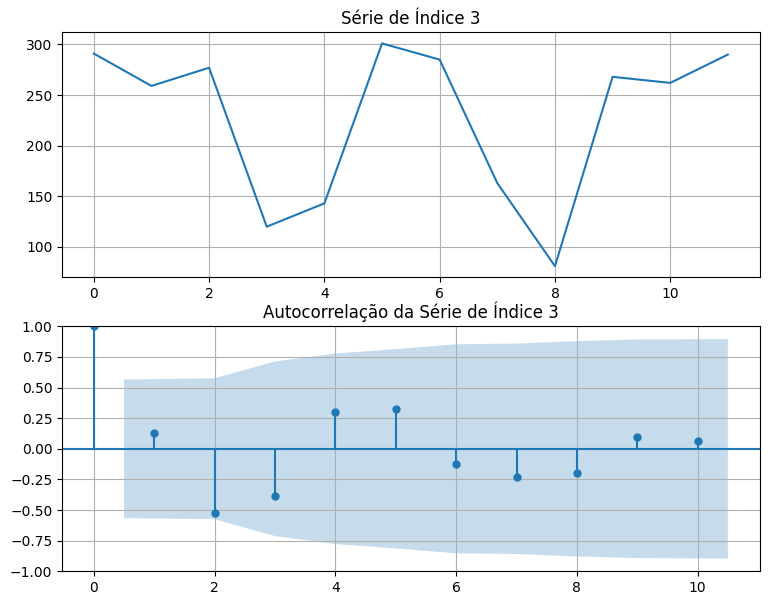

============================================ ACF day_of_week 4 ============================================


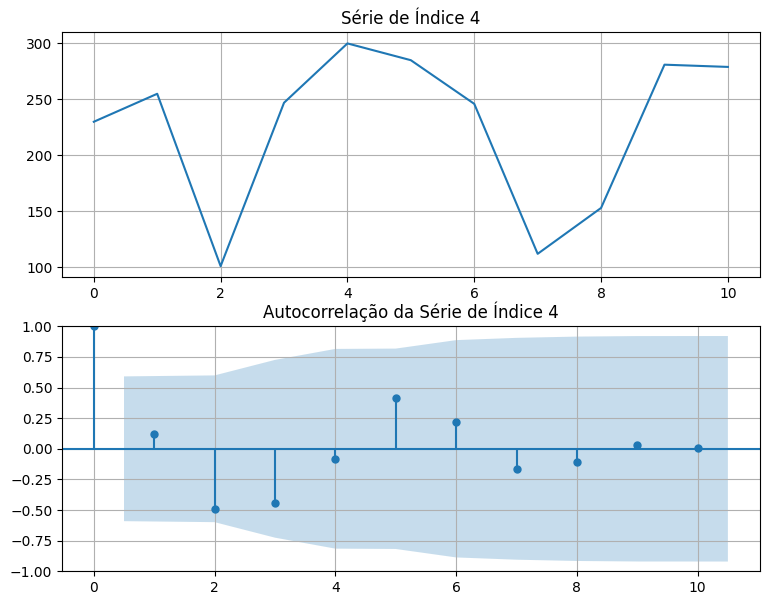

In [38]:
# PACF
for idx, df in enumerate(dfs_ARIMA):

    print('============================================', 'ACF day_of_week',idx, '============================================')

    fig, axes = plt.subplots(2,1, sharex=False)


    axes[0].plot(df.Volume); axes[0].set_title('Série de Índice {}'.format(idx))
    plot_acf(df.Volume, ax=axes[1], lags=10, title='Autocorrelação da Série de Índice {}'.format(idx))
    axes[0].grid(visible=True),axes[1].grid(visible=True)
    plt.show()



Nos modelos ARIMA, a componente de média móvel raramente ultrapassa 3 ou 4. Por isso, utilizaremos o valor 2 para manter o modelo simples.

### Modelagem

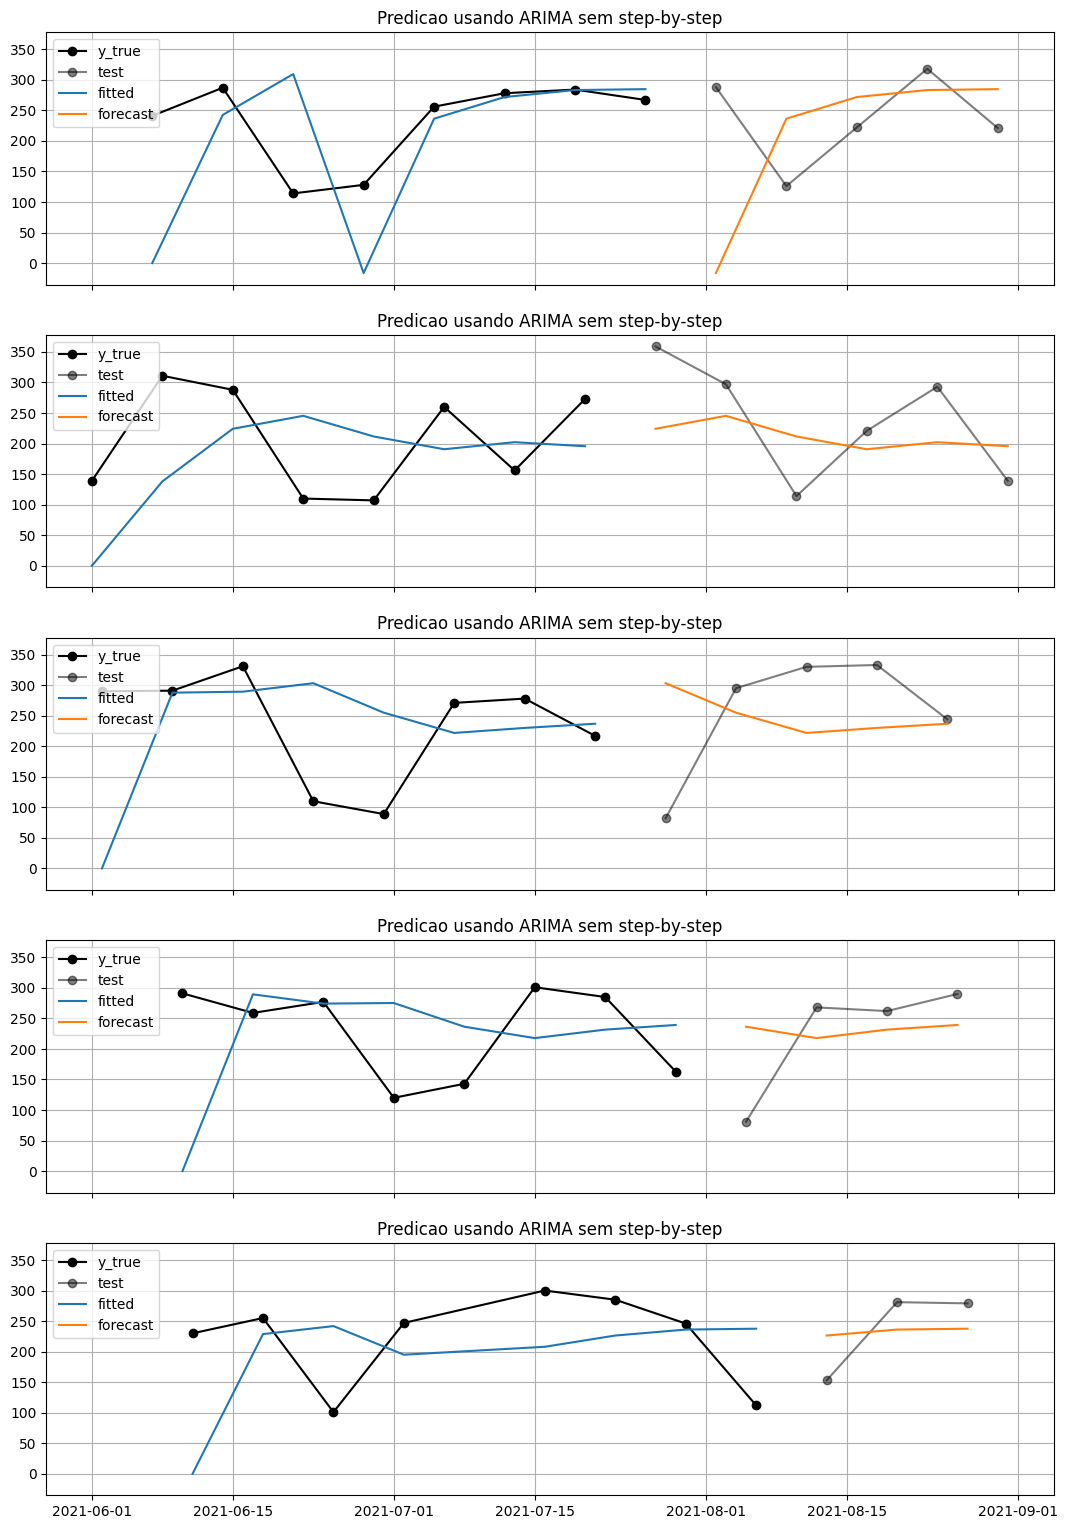

In [49]:
p = 0 #Autoregressao
d = 1 #Diferenciacao
q = 1 #MediaMovel
# steps = 5 # Steps a serem previstos

fig, ax = plt.subplots(nrows=5,figsize=(13,19), sharex= True, sharey = True)
# Instancia o modelo e faz o fit no treino
for idx, df in enumerate(dfs_ARIMA):


    model = ARIMA(df['Volume'][:8],order=(p,d,q)).fit()

# Realiza FORECAST
    if idx == 0:
        fc = model.predict(3, alpha=0.05)  # 95% conf
    if idx == 1:
        fc = model.predict(2, alpha=0.05)  # 95% conf
    if idx == 2:
        fc = model.predict(3, alpha=0.05)  # 95% conf
    if idx == 3:
        fc = model.predict(4, alpha=0.05)  # 95% conf
    if idx == 4:
        fc = model.predict(5, alpha=0.05)  # 95% conf

# Plot
    ax[idx].plot(df['Data'][:8],df['Volume'][:8], marker="o", color="black")

    ax[idx].plot(df['Data'][8:],df['Volume'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],model.fittedvalues)

    ax[idx].plot(df['Data'][8:],fc)

    ax[idx].legend(loc = 'upper left', labels = ['y_true','test', 'fitted', 'forecast'])
    ax[idx].grid(visible=True)
    ax[idx].set_title('Predicao usando ARIMA sem step-by-step')

plt.show()


In [40]:
dfs_ARIMA_finais[1]

NameError: name 'dfs_ARIMA_finais' is not defined

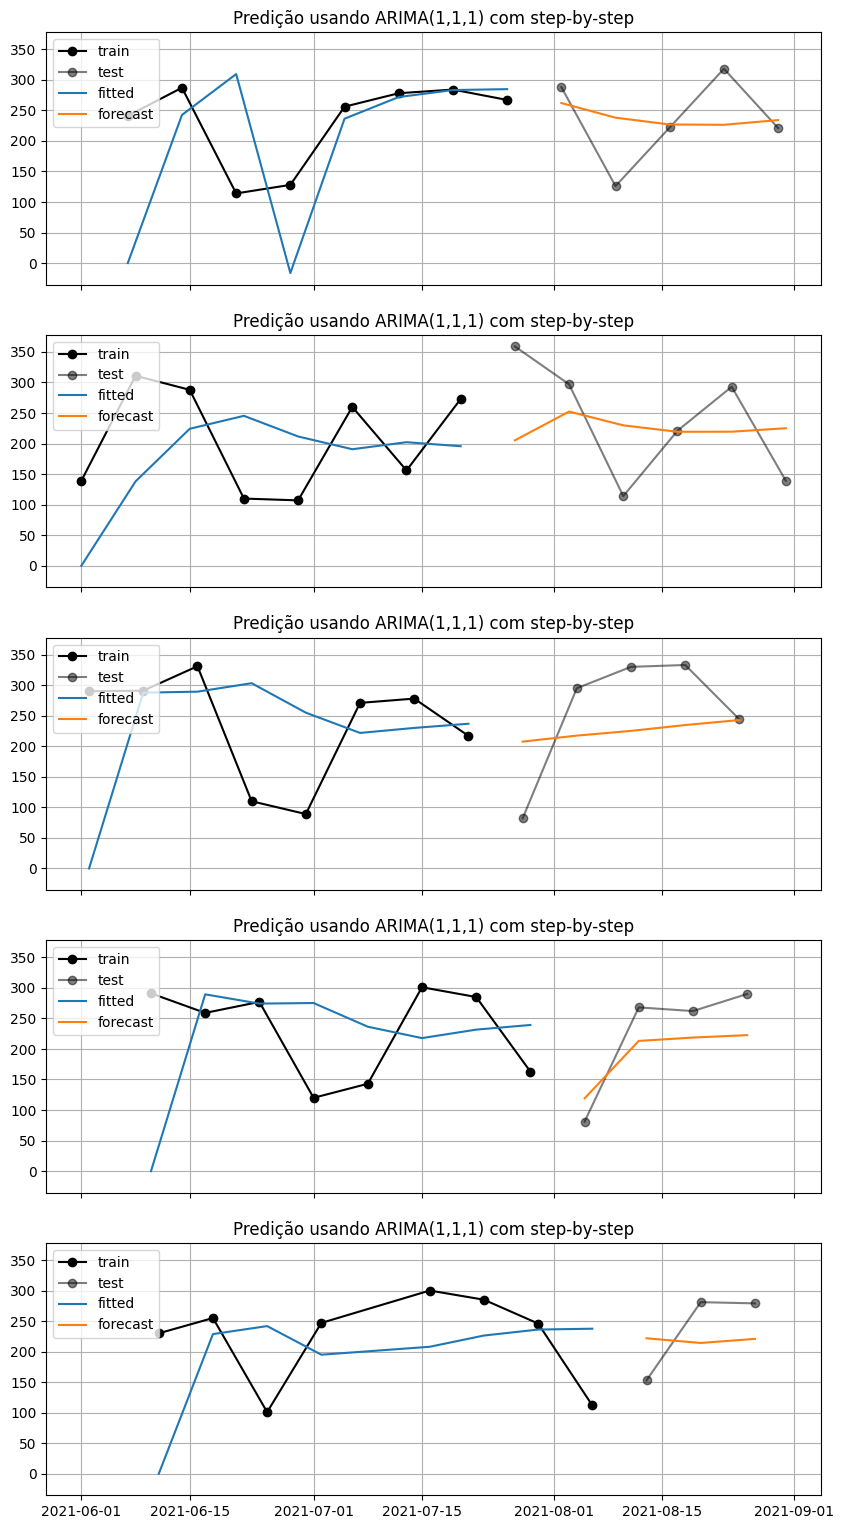

In [ ]:
p = 0 #Autoregressao
d = 1 #Diferenciacao
q = 1 #MediaMovel

# steps = 5 # Steps a serem previstos
dfs_ARIMA_finais = [[],[],[],[],[]]
fig, ax = plt.subplots(nrows=5,figsize=(10,19), sharex= True, sharey = True)

# Instancia o modelo e faz o fit no treino
for idx, df in enumerate(dfs_ARIMA):

    results = list()
    df_results_ARIMA = pd.DataFrame()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            ARIMA_base = ARIMA(X['Volume'],order=(p,d,q)).fit()
            [results.append(ARIMA_base.fittedvalues[i]) for i in range(len(ARIMA_base.fittedvalues))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            ARIMA_step = ARIMA(X['Volume'],order=(p,d,q)).fit()
            results.append(ARIMA_step.fittedvalues[i-1])

    df_results_ARIMA = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)

    df = pd.concat([df,pd.Series(results, name = 'ARIMA')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_ARIMA_finais[idx] = df.copy()

    ax[idx].plot(df['Data'][:8],df['y_true'][:8], marker="o", color="black")
    ax[idx].plot(df['Data'][8:],df['y_true'][8:], marker="o", color="black", alpha = 0.5)

    ax[idx].plot(df['Data'][:8],df['y_pred'][:8])

    ax[idx].plot(df['Data'][8:],df['y_pred'][8:])

    ax[idx].grid(visible=True)
    ax[idx].set_title('Predição usando ARIMA(1,1,1) com step-by-step')
    ax[idx].legend(loc = 'upper left', labels = ['train', 'test','fitted','forecast'])


### calculo do erro

In [ ]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

for idx, df in enumerate(dfs_ARIMA_finais):
    print('=================================================', 'errors day_of_week',idx,'=================================================')

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error( dfs_ARIMA_finais[idx]['y_true'][8:],
                                dfs_ARIMA_finais[idx]['y_pred'][8:],
                                squared=False))
    print('\t erro (MAE) da previsao \t',
        mean_absolute_error( dfs_ARIMA_finais[idx]['y_true'][8:],
                            dfs_ARIMA_finais[idx]['y_pred'][8:]))
    print('\t RMSE da média da previsao \t',
            mean_squared_error( dfs_ARIMA_finais[idx]['y_true'][8:],
                                [dfs_ARIMA_finais[idx]['y_true'].mean() for i in range(dfs_ARIMA_finais[idx]['y_true'][8:].shape[0])],
                                squared=False))



DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================
	 erro (RMSE) da previsao 	 66.04652401025285
	 erro (MAE) da previsao 	 49.49964549437422
	 RMSE da média da previsao 	 66.27592492641706
================================================= errors day_of_week 1 =================================================
	 erro (RMSE) da previsao 	 92.96971451326024
	 erro (MAE) da previsao 	 79.25293458190448
	 RMSE da média da previsao 	 89.97542181402788
================================================= errors day_of_week 2 =================================================
	 erro (RMSE) da previsao 	 92.13469869481257
	 erro (MAE) da previsao 	 81.46911688293814
	 RMSE da média da previsao 	 94.09982738981458
================================================= errors day_of_week 3 =================================================
	 erro (RMSE) da previsao 	 

## Calculo dos erros

In [ ]:
print('DF0 = Segundas')
print('DF1 = Tercas')
print('DF2 = Quartas')
print('DF3 = Quintas')
print('DF4 = Sextas')
print()
print()

erros_todos = []

for idx in range(5):

    data = [{   'ARIMA':mean_squared_error(dfs_ARIMA_finais[idx]['y_true'][8:],        dfs_ARIMA_finais[idx]['y_pred'][8:],squared=False),\
                'MA4': mean_squared_error(dfs_MA[idx]['y_true'][8:],           dfs_MA[idx]['y_pred'][8:],squared=False),\
                'SEH':  mean_squared_error(dfs_SEH[idx]['y_true'][8:],          dfs_SEH[idx]['y_pred'][8:],squared=False),\
                'SES':  mean_squared_error(dfs_SES[idx]['y_true'][8:],          dfs_SES[idx]['y_pred'][8:],squared=False),\
                'HW':   mean_squared_error(dfs_HW[idx]['y_true'][8:],           dfs_HW[idx]['y_pred'][8:],squared=False)},\

        {       'ARIMA':mean_absolute_error(dfs_ARIMA_finais[idx]['y_true'][8:],    dfs_ARIMA_finais[idx]['y_pred'][8:]),\
                'MA4': mean_absolute_error(dfs_MA[idx]['y_true'][8:],       dfs_MA[idx]['y_pred'][8:] ),\
                'SEH':  mean_absolute_error(dfs_SEH[idx]['y_true'][8:],      dfs_SEH[idx]['y_pred'][8:]),\
                'SES':  mean_absolute_error(dfs_SES[idx]['y_true'][8:],      dfs_SES[idx]['y_pred'][8:]),\
                'HW':   mean_absolute_error(dfs_HW[idx]['y_true'][8:],       dfs_HW[idx]['y_pred'][8:]   )}]


    erros_todos.append(pd.DataFrame.from_records(data, index=['RMSE','MAE']))

for idx in range(5):
    print('=================================================', 'errors day_of_week',idx,'=================================================')
    display(erros_todos[idx])


DF0 = Segundas
DF1 = Tercas
DF2 = Quartas
DF3 = Quintas
DF4 = Sextas


================================================= errors day_of_week 0 =================================================


ARIMA      MA4      SEH      SES        HW
RMSE 66.04652 62.75986 56.95316 63.21108 252.06532
MAE  49.49965 41.60000 42.94203 50.37474 227.70650

================================================= errors day_of_week 1 =================================================


ARIMA      MA4       SEH      SES       HW
RMSE 92.96971 80.53862 147.19341 86.82632 81.23404
MAE  79.25293 68.45833 140.80356 76.35939 65.76618

================================================= errors day_of_week 2 =================================================


ARIMA      MA4      SEH      SES        HW
RMSE 92.13470 90.72073 85.24665 89.86391 136.04616
MAE  81.46912 87.10000 77.57896 78.22408 116.78687

================================================= errors day_of_week 3 =================================================


ARIMA      MA4      SEH      SES       HW
RMSE 52.16039 86.04305 72.39056 79.49509 71.78832
MAE  50.92741 82.12500 72.06077 70.61818 47.97213

================================================= errors day_of_week 4 =================================================


ARIMA      MA4      SEH      SES       HW
RMSE 64.75192 69.03517 50.21247 58.14334 80.67683
MAE  64.58461 67.25000 48.46928 58.02020 59.56917

In [ ]:
erros_scaled = []


for idx in range(5):

    erros_scaled.append(erros_todos[idx].copy())

    erros_scaled[idx].loc['RMSE',:] = (erros_todos[idx].loc['RMSE',:]- erros_todos[idx].loc['RMSE',:].min() ) / (erros_todos[idx].loc['RMSE',:].max() - erros_todos[idx].loc['RMSE',:].min())

    erros_scaled[idx].loc['MAE',:] = (erros_todos[idx].loc['MAE',:]- erros_todos[idx].loc['MAE',:].min() ) / (erros_todos[idx].loc['MAE',:].max() - erros_todos[idx].loc['MAE',:].min())


for idx in range(5):
    print('=================================================', 'errors day_of_week',idx,'=================================================')
    display(erros_scaled[idx])

================================================= errors day_of_week 0 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.04661 0.02976 0.00000 0.03207 1.00000
MAE  0.04245 0.00000 0.00721 0.04715 1.00000

================================================= errors day_of_week 1 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.18650 0.00000 1.00000 0.09433 0.01043
MAE  0.17973 0.03588 1.00000 0.14117 0.00000

================================================= errors day_of_week 2 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.13559 0.10776 0.00000 0.09089 1.00000
MAE  0.09922 0.24283 0.00000 0.01645 1.00000

================================================= errors day_of_week 3 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.00000 1.00000 0.59707 0.80675 0.57929
MAE  0.08653 1.00000 0.70532 0.66308 0.00000

================================================= errors day_of_week 4 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.47726 0.61786 0.00000 0.26033 1.00000
MAE  0.85808 1.00000 0.00000 0.50855 0.59103

In [ ]:
erros_min = []


for idx in range(5):

    erros_min.append(erros_todos[idx].copy())

    erros_min[idx].loc['RMSE',:] = (erros_todos[idx].loc['RMSE',:] / erros_todos[idx].loc['RMSE',:].min() -1) *100

    erros_min[idx].loc['MAE',:] = (erros_todos[idx].loc['MAE',:] / erros_todos[idx].loc['MAE',:].min() -1) *100


for idx in range(5):
    print('=================================================', 'errors day_of_week',idx,'=================================================')
    display(erros_min[idx])

================================================= errors day_of_week 0 =================================================


ARIMA      MA4     SEH      SES        HW
RMSE 15.96640 10.19558 0.00000 10.98784 342.58357
MAE  18.98953  0.00000 3.22603 21.09313 447.37140

================================================= errors day_of_week 1 =================================================


ARIMA     MA4       SEH      SES      HW
RMSE 15.43495 0.00000  82.76129  7.80707 0.86347
MAE  20.50713 4.09352 114.09722 16.10738 0.00000

================================================= errors day_of_week 2 =================================================


ARIMA      MA4     SEH     SES       HW
RMSE 8.08014  6.42146 0.00000 5.41635 59.59122
MAE  5.01444 12.27270 0.00000 0.83156 50.53935

================================================= errors day_of_week 3 =================================================


ARIMA      MA4      SEH      SES       HW
RMSE 0.00000 64.95858 38.78453 52.40507 37.62995
MAE  6.16041 71.19313 50.21380 47.20667  0.00000

================================================= errors day_of_week 4 =================================================


ARIMA      MA4     SEH      SES       HW
RMSE 28.95585 37.48610 0.00000 15.79462 60.67090
MAE  33.24854 38.74768 0.00000 19.70510 22.90087

In [ ]:
erros_viagens = []

for idx,df_ in enumerate([segundas, tercas, quartas, quintas, sextas]):
    
    erros_viagens.append(erros_todos[idx].copy())

    erros_viagens[idx] = erros_todos[idx] / df_.Volume.sum()

for idx in range(5):
    print('=================================================', 'errors day_of_week',idx,'=================================================')
    display(erros_viagens[idx])

================================================= errors day_of_week 0 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.02180 0.02071 0.01880 0.02086 0.08319
MAE  0.01634 0.01373 0.01417 0.01663 0.07515

================================================= errors day_of_week 1 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.03031 0.02626 0.04799 0.02831 0.02649
MAE  0.02584 0.02232 0.04591 0.02490 0.02144

================================================= errors day_of_week 2 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.02915 0.02870 0.02697 0.02843 0.04304
MAE  0.02577 0.02755 0.02454 0.02475 0.03695

================================================= errors day_of_week 3 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.01904 0.03140 0.02642 0.02901 0.02620
MAE  0.01859 0.02997 0.02630 0.02577 0.01751

================================================= errors day_of_week 4 =================================================


ARIMA     MA4     SEH     SES      HW
RMSE 0.02602 0.02774 0.02017 0.02336 0.03241
MAE  0.02595 0.02702 0.01947 0.02331 0.02393

In [ ]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('../Output de dados/erros_viagens_diaria.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# erros_viagens[0].to_excel(writer, sheet_name='segundas')
# erros_viagens[1].to_excel(writer, sheet_name='tercas')
# erros_viagens[2].to_excel(writer, sheet_name='quartas')
# erros_viagens[3].to_excel(writer, sheet_name='quintas')
# erros_viagens[4].to_excel(writer, sheet_name='sextas')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()
